In [2]:
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas_datareader as data_reader
import datetime

from tqdm import tqdm_notebook, tqdm
from collections import deque

In [3]:
print(data_reader.__version__)
print(tf.__version__)

0.10.0
2.10.0


In [4]:
class AI_Trader():
  
    def __init__(self, state_size, action_space=3, model_name="AITrader"):

        self.state_size = state_size
        self.action_space = action_space
        self.memory = deque(maxlen = 2000)
        self.inventory = []
        self.model = self.model_builder()
        self.model_name = self.model.name

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_final = 0.01
        self.epsilon_decay = 0.995
  
    def model_builder(self):

        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(units=32, activation='relu', input_dim=self.state_size))
        model.add(tf.keras.layers.Dense(units=64, activation='relu'))
        model.add(tf.keras.layers.Dense(units=128, activation='relu'))
        model.add(tf.keras.layers.Dense(units=self.action_space, activation='linear'))
        model.compile(loss='mse', optimizer="Adam")
        
        return model

    def trade(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_space)
        act_values = self.model.predict(state)
        
        return np.argmax(act_values[0])
    
    def batch_train(self, batch_size):

        batch = []
        for i in range(len(self.memory) - batch_size + 1, len(self.memory)):
            batch.append(self.memory[i])

        for state, action, reward, next_state, done in batch:
            target = self.model.predict(state)

        if not done:
            target[0][action] = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

        target[0][action] = reward

        self.model.fit(state, target, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_final:
            self.epsilon *= self.epsilon_decay

In [5]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def stocks_price_format(n):
    if n < 0:
        return "- # {0:2f}".format(abs(n))
    else:
        return "$ {0:2f}".format(abs(n))

def dataset_loader(stock_name):

    dataset = data_reader.DataReader(stock_name, data_source="yahoo")

    start_date = str(dataset.index[0]).split()[0]
    end_date = str(dataset.index[1]).split()[0]

    close = dataset['Close']

    return close

def state_creator(data, timestep, window_size):
  
    starting_id = timestep - window_size + 1
    if starting_id >= 0:
        windowed_data = data[starting_id:timestep+1]
    else:
        windowed_data = starting_id * [data[0]] + list(data[0:timestep+1])
        
    state = []
    for i in range(window_size - 1):
        state.append(sigmoid(windowed_data[i+1] - windowed_data[i]))

    return np.array([state])

In [6]:
stock_name = "AAPL"
data = dataset_loader(stock_name).iloc[-50:]
data

Date
2022-09-06    154.529999
2022-09-07    155.960007
2022-09-08    154.460007
2022-09-09    157.369995
2022-09-12    163.429993
2022-09-13    153.839996
2022-09-14    155.309998
2022-09-15    152.369995
2022-09-16    150.699997
2022-09-19    154.479996
2022-09-20    156.899994
2022-09-21    153.720001
2022-09-22    152.740005
2022-09-23    150.429993
2022-09-26    150.770004
2022-09-27    151.759995
2022-09-28    149.839996
2022-09-29    142.479996
2022-09-30    138.199997
2022-10-03    142.449997
2022-10-04    146.100006
2022-10-05    146.399994
2022-10-06    145.429993
2022-10-07    140.089996
2022-10-10    140.419998
2022-10-11    138.979996
2022-10-12    138.339996
2022-10-13    142.990005
2022-10-14    138.380005
2022-10-17    142.410004
2022-10-18    143.750000
2022-10-19    143.860001
2022-10-20    143.389999
2022-10-21    147.270004
2022-10-24    149.449997
2022-10-25    152.339996
2022-10-26    149.350006
2022-10-27    144.800003
2022-10-28    155.740005
2022-10-31    153.33

In [67]:
window_size = 5
episodes = 10
capital = 10000

batch_size = 8
data_samples = len(data) - 1

In [68]:
trader = AI_Trader(window_size)
trader.model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 32)                192       
                                                                 
 dense_17 (Dense)            (None, 64)                2112      
                                                                 
 dense_18 (Dense)            (None, 128)               8320      
                                                                 
 dense_19 (Dense)            (None, 3)                 387       
                                                                 
Total params: 11,011
Trainable params: 11,011
Non-trainable params: 0
_________________________________________________________________


In [69]:
assets = []
start_time = datetime.datetime.now()
for episode in range(1, episodes + 1):
  
    print("Episode: {}/{}".format(episode, episodes))

    state = state_creator(data, 10, window_size + 1)

    action = [0]
    cash = capital
    trader.inventory = []
    sells = []
    buys = []
    closes = []
    asset = 0
    # for t in tqdm(range(data_samples)):
    for t in tqdm(range(window_size,data_samples)):
        closes.append(data[t])
        
        action = trader.trade(state)

        next_state = state_creator(data, t+1, window_size + 1)
        reward = 0
        if action == 1 and cash > data[t]: #Buying
            stock = divmod(cash, data[t])
            trader.inventory.append((data[t],stock[0]))
            asset = cash
            cash -= data[t]*stock[0]
            buys.append(data[t])
            sells.append(None)
            print("purchase price: {0:.2f}, amount of purchase: {1}, cash: {2:.2f}".format(data[t],stock[0],stock[1]))
      
        elif action == 2 and len(trader.inventory) > 0: #Selling
            buy_stock = trader.inventory.pop(0)

            reward = max((data[t] - buy_stock[0])*buy_stock[1], 0)
            cash += data[t]*buy_stock[1]
            asset = cash
            sells.append(data[t])
            buys.append(None)
            print("selling price: {0:.2f}, amount of selling: {1}, cash: {2:.2f}".format(data[t],buy_stock[1],cash))
        else:
            buys.append(None)
            sells.append(None)
        if t == data_samples - 1:
            done = True
        else:
            done = False
      
        trader.memory.append((state, action, reward, next_state, done))

        state = next_state

        if done:
            print("########################")
            print("TOTAL ASSET: {:.2f}".format(asset))
            print("########################")
            assets.append(asset)
        if len(trader.memory) > batch_size:
            trader.batch_train(batch_size)
      
    if episode % 10 == 0:
        trader.model.save("ai_trader_{}.h5".format(episode))
end_time = datetime.datetime.now()
print("총 소요 시간: {}".format(end_time - start_time))

Episode: 1/10


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

purchase price: 156.90, amount of purchase: 63.0, cash: 115.30
selling price: 153.72, amount of selling: 63.0, cash: 9799.66
1/1 [==============================] - 0s 22ms/step


 20%|████████████████▉                                                                  | 9/44 [00:01<00:04,  7.47it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██████████████████▋                                                               | 10/44 [00:01<00:07,  4.78it/s]

1/1 [==============================] - 0s 24ms/step


 25%|████████████████████▌                                                             | 11/44 [00:02<00:09,  3.44it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:03<00:11,  2.81it/s]

1/1 [==============================] - 0s 15ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:03<00:12,  2.39it/s]

purchase price: 138.20, amount of purchase: 70.0, cash: 125.66
1/1 [==============================] - 0s 11ms/step


 32%|██████████████████████████                                                        | 14/44 [00:04<00:14,  2.14it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:05<00:14,  1.95it/s]

selling price: 146.10, amount of selling: 70.0, cash: 10352.66
1/1 [==============================] - 0s 19ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:05<00:15,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:06<00:15,  1.74it/s]

purchase price: 145.43, amount of purchase: 71.0, cash: 27.13
1/1 [==============================] - 0s 10ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:07<00:15,  1.68it/s]

1/1 [==============================] - 0s 30ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:07<00:16,  1.56it/s]

1/1 [==============================] - 0s 34ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:08<00:17,  1.39it/s]

selling price: 138.98, amount of selling: 71.0, cash: 9894.71
1/1 [==============================] - 0s 7ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:09<00:16,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:10<00:15,  1.44it/s]

purchase price: 142.99, amount of purchase: 69.0, cash: 28.40
1/1 [==============================] - 0s 22ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:10<00:14,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:11<00:16,  1.22it/s]

1/1 [==============================] - 0s 19ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:12<00:14,  1.31it/s]

1/1 [==============================] - 0s 11ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:13<00:13,  1.37it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:13<00:12,  1.39it/s]

1/1 [==============================] - 0s 8ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:14<00:11,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:15<00:10,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:16<00:10,  1.38it/s]

1/1 [==============================] - 0s 20ms/step
selling price: 152.34, amount of selling: 69.0, cash: 10539.86
1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:16<00:09,  1.37it/s]

purchase price: 149.35, amount of purchase: 70.0, cash: 85.36
1/1 [==============================] - 0s 21ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:17<00:08,  1.40it/s]

1/1 [==============================] - 0s 32ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:18<00:08,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:18<00:07,  1.40it/s]

selling price: 153.34, amount of selling: 70.0, cash: 10819.16
1/1 [==============================] - 0s 23ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:19<00:06,  1.42it/s]

purchase price: 150.65, amount of purchase: 71.0, cash: 123.01
1/1 [==============================] - 0s 23ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:20<00:05,  1.44it/s]

1/1 [==============================] - 0s 27ms/step
selling price: 145.03, amount of selling: 71.0, cash: 10420.14
1/1 [==============================] - 0s 23ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:21<00:05,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:21<00:04,  1.40it/s]

purchase price: 138.38, amount of purchase: 75.0, cash: 41.64
1/1 [==============================] - 0s 31ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:22<00:03,  1.39it/s]

1/1 [==============================] - 0s 28ms/step
selling price: 138.92, amount of selling: 75.0, cash: 10460.64
1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:23<00:03,  1.28it/s]

1/1 [==============================] - 0s 7ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:24<00:02,  1.31it/s]

purchase price: 134.87, amount of purchase: 77.0, cash: 75.65
1/1 [==============================] - 0s 20ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:24<00:01,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:25<00:00,  1.39it/s]

selling price: 149.70, amount of selling: 77.0, cash: 11602.55
########################
TOTAL ASSET: 11602.55
########################
1/1 [==============================] - 0s 17ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:26<00:00,  1.69it/s]


Episode: 2/10


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:28,  1.49it/s]

1/1 [==============================] - 0s 27ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:30,  1.36it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:31,  1.32it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███████▌                                                                           | 4/44 [00:02<00:29,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█████████▍                                                                         | 5/44 [00:03<00:27,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:26,  1.45it/s]

1/1 [==============================] - 0s 10ms/step


 16%|█████████████▏                                                                     | 7/44 [00:04<00:24,  1.49it/s]

purchase price: 152.74, amount of purchase: 65.0, cash: 71.90
1/1 [==============================] - 0s 26ms/step


 18%|███████████████                                                                    | 8/44 [00:05<00:24,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 20%|████████████████▉                                                                  | 9/44 [00:06<00:23,  1.51it/s]

selling price: 150.77, amount of selling: 65.0, cash: 9871.95
1/1 [==============================] - 0s 17ms/step


 23%|██████████████████▋                                                               | 10/44 [00:06<00:22,  1.52it/s]

purchase price: 151.76, amount of purchase: 65.0, cash: 7.55
1/1 [==============================] - 0s 21ms/step


 25%|████████████████████▌                                                             | 11/44 [00:07<00:22,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:08<00:21,  1.48it/s]

selling price: 142.48, amount of selling: 65.0, cash: 9268.75
1/1 [==============================] - 0s 17ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:08<00:20,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 32%|██████████████████████████                                                        | 14/44 [00:09<00:20,  1.48it/s]

purchase price: 142.45, amount of purchase: 65.0, cash: 9.50
1/1 [==============================] - 0s 18ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:10<00:19,  1.48it/s]

1/1 [==============================] - 0s 14ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:10<00:18,  1.51it/s]

1/1 [==============================] - 0s 18ms/step
selling price: 146.40, amount of selling: 65.0, cash: 9525.50
1/1 [==============================] - 0s 18ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:11<00:18,  1.48it/s]

1/1 [==============================] - 0s 14ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:12<00:17,  1.49it/s]

1/1 [==============================] - 0s 10ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:12<00:16,  1.50it/s]

1/1 [==============================] - 0s 29ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:13<00:17,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:14<00:16,  1.36it/s]

1/1 [==============================] - 0s 15ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:15<00:15,  1.41it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:15<00:14,  1.42it/s]

1/1 [==============================] - 0s 10ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:16<00:13,  1.46it/s]

purchase price: 142.41, amount of purchase: 66.0, cash: 126.44
1/1 [==============================] - 0s 22ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:17<00:12,  1.49it/s]

1/1 [==============================] - 0s 7ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:17<00:12,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:18<00:11,  1.51it/s]

selling price: 143.39, amount of selling: 66.0, cash: 9590.18
1/1 [==============================] - 0s 23ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:19<00:10,  1.53it/s]

purchase price: 147.27, amount of purchase: 65.0, cash: 17.63
1/1 [==============================] - 0s 22ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:19<00:10,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:20<00:09,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:21<00:08,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:22<00:09,  1.24it/s]

1/1 [==============================] - 0s 21ms/step
selling price: 144.80, amount of selling: 65.0, cash: 9429.63
1/1 [==============================] - 0s 19ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:22<00:08,  1.29it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:23<00:07,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:24<00:06,  1.42it/s]

1/1 [==============================] - 0s 10ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:24<00:05,  1.40it/s]

1/1 [==============================] - 0s 10ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:25<00:04,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:26<00:04,  1.48it/s]

1/1 [==============================] - 0s 11ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:26<00:03,  1.50it/s]

1/1 [==============================] - 0s 26ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:27<00:02,  1.39it/s]

1/1 [==============================] - 0s 30ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:28<00:02,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:29<00:01,  1.37it/s]

purchase price: 146.87, amount of purchase: 64.0, cash: 29.95
1/1 [==============================] - 0s 22ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:29<00:00,  1.40it/s]

selling price: 149.70, amount of selling: 64.0, cash: 9610.75
########################
TOTAL ASSET: 9610.75
########################
1/1 [==============================] - 0s 21ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:30<00:00,  1.44it/s]


Episode: 3/10


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:27,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:26,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


  7%|█████▋                                                                             | 3/44 [00:01<00:27,  1.48it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▌                                                                           | 4/44 [00:02<00:27,  1.45it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█████████▍                                                                         | 5/44 [00:03<00:26,  1.48it/s]

1/1 [==============================] - 0s 14ms/step


 14%|███████████▎                                                                       | 6/44 [00:03<00:25,  1.51it/s]

purchase price: 153.72, amount of purchase: 65.0, cash: 8.20
1/1 [==============================] - 0s 8ms/step


 16%|█████████████▏                                                                     | 7/44 [00:04<00:24,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████████████                                                                    | 8/44 [00:05<00:24,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 20%|████████████████▉                                                                  | 9/44 [00:06<00:24,  1.43it/s]

1/1 [==============================] - 0s 14ms/step
selling price: 150.77, amount of selling: 65.0, cash: 9808.25
1/1 [==============================] - 0s 11ms/step


 23%|██████████████████▋                                                               | 10/44 [00:06<00:24,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 25%|████████████████████▌                                                             | 11/44 [00:07<00:22,  1.44it/s]

1/1 [==============================] - 0s 9ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:08<00:22,  1.43it/s]

1/1 [==============================] - 0s 15ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:08<00:21,  1.46it/s]

1/1 [==============================] - 0s 15ms/step


 32%|██████████████████████████                                                        | 14/44 [00:09<00:20,  1.43it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:10<00:21,  1.37it/s]

1/1 [==============================] - 0s 14ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:11<00:20,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:11<00:19,  1.35it/s]

1/1 [==============================] - 0s 7ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:12<00:18,  1.41it/s]

1/1 [==============================] - 0s 24ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:13<00:17,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:13<00:16,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:14<00:15,  1.44it/s]

1/1 [==============================] - 0s 13ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:15<00:15,  1.40it/s]

purchase price: 142.99, amount of purchase: 68.0, cash: 84.93
1/1 [==============================] - 0s 16ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:16<00:14,  1.43it/s]

selling price: 138.38, amount of selling: 68.0, cash: 9494.77
1/1 [==============================] - 0s 21ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:16<00:13,  1.46it/s]

purchase price: 142.41, amount of purchase: 66.0, cash: 95.71
1/1 [==============================] - 0s 9ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:17<00:12,  1.47it/s]

1/1 [==============================] - 0s 26ms/step
selling price: 143.75, amount of selling: 66.0, cash: 9583.21
1/1 [==============================] - 0s 31ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:18<00:13,  1.38it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:18<00:11,  1.43it/s]

1/1 [==============================] - 0s 31ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:19<00:11,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:20<00:10,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:20<00:09,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:21<00:09,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:22<00:08,  1.46it/s]

1/1 [==============================] - 0s 27ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:23<00:07,  1.40it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:24<00:07,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:24<00:06,  1.34it/s]

1/1 [==============================] - 0s 31ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:25<00:06,  1.26it/s]

1/1 [==============================] - 0s 63ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:26<00:06,  1.06it/s]

1/1 [==============================] - 0s 78ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:28<00:06,  1.04s/it]

1/1 [==============================] - 0s 16ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:29<00:05,  1.13s/it]

1/1 [==============================] - 0s 16ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:30<00:04,  1.03s/it]

1/1 [==============================] - 0s 30ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:31<00:02,  1.06it/s]

1/1 [==============================] - 0s 20ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:31<00:01,  1.13it/s]

1/1 [==============================] - 0s 20ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:32<00:00,  1.19it/s]

purchase price: 149.70, amount of purchase: 64.0, cash: 2.41
########################
TOTAL ASSET: 9583.21
########################
1/1 [==============================] - 0s 22ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:33<00:00,  1.33it/s]


Episode: 4/10


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:25,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:26,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


  7%|█████▋                                                                             | 3/44 [00:01<00:25,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


  9%|███████▌                                                                           | 4/44 [00:02<00:26,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█████████▍                                                                         | 5/44 [00:03<00:25,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:26,  1.42it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█████████████▏                                                                     | 7/44 [00:04<00:26,  1.37it/s]

1/1 [==============================] - 0s 30ms/step


 18%|███████████████                                                                    | 8/44 [00:05<00:25,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 20%|████████████████▉                                                                  | 9/44 [00:06<00:24,  1.42it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██████████████████▋                                                               | 10/44 [00:06<00:23,  1.44it/s]

purchase price: 151.76, amount of purchase: 65.0, cash: 135.60
1/1 [==============================] - 0s 20ms/step


 25%|████████████████████▌                                                             | 11/44 [00:07<00:21,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:07<00:20,  1.56it/s]

1/1 [==============================] - 0s 15ms/step
selling price: 142.48, amount of selling: 65.0, cash: 9396.80
1/1 [==============================] - 0s 20ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:08<00:20,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 32%|██████████████████████████                                                        | 14/44 [00:09<00:19,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:09<00:18,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:10<00:18,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:11<00:16,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:11<00:16,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:12<00:16,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:13<00:15,  1.56it/s]

1/1 [==============================] - 0s 15ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:13<00:14,  1.55it/s]

purchase price: 138.34, amount of purchase: 67.0, cash: 128.02
1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:14<00:13,  1.59it/s]

1/1 [==============================] - 0s 15ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:14<00:12,  1.62it/s]

1/1 [==============================] - 0s 24ms/step
selling price: 138.38, amount of selling: 67.0, cash: 9399.48
1/1 [==============================] - 0s 20ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:15<00:12,  1.60it/s]

purchase price: 142.41, amount of purchase: 66.0, cash: 0.42
1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:16<00:12,  1.49it/s]

selling price: 143.75, amount of selling: 66.0, cash: 9487.92
1/1 [==============================] - 0s 25ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:17<00:12,  1.47it/s]

purchase price: 143.86, amount of purchase: 65.0, cash: 137.02
1/1 [==============================] - 0s 24ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:17<00:11,  1.43it/s]

1/1 [==============================] - 0s 26ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:18<00:11,  1.41it/s]

1/1 [==============================] - 0s 27ms/step
selling price: 147.27, amount of selling: 65.0, cash: 9709.57
1/1 [==============================] - 0s 25ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:19<00:11,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:20<00:10,  1.33it/s]

1/1 [==============================] - 0s 29ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:20<00:10,  1.30it/s]

1/1 [==============================] - 0s 9ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:21<00:09,  1.30it/s]

1/1 [==============================] - 0s 20ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:22<00:08,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:23<00:07,  1.38it/s]

1/1 [==============================] - 0s 8ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:23<00:06,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:24<00:05,  1.41it/s]

1/1 [==============================] - 0s 8ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:25<00:05,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:26<00:04,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:27<00:04,  1.16it/s]

1/1 [==============================] - 0s 17ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:27<00:03,  1.25it/s]

1/1 [==============================] - 0s 27ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:28<00:02,  1.28it/s]

1/1 [==============================] - 0s 14ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:29<00:01,  1.32it/s]

1/1 [==============================] - 0s 15ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:29<00:00,  1.36it/s]

1/1 [==============================] - 0s 17ms/step
########################
TOTAL ASSET: 9709.57
########################
1/1 [==============================] - 0s 17ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:30<00:00,  1.44it/s]


Episode: 5/10


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

purchase price: 153.84, amount of purchase: 65.0, cash: 0.40
1/1 [==============================] - 0s 12ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:27,  1.55it/s]

1/1 [==============================] - 0s 16ms/step
selling price: 155.31, amount of selling: 65.0, cash: 10095.55
1/1 [==============================] - 0s 19ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:28,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:28,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


  9%|███████▌                                                                           | 4/44 [00:02<00:27,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█████████▍                                                                         | 5/44 [00:03<00:27,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:26,  1.41it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▏                                                                     | 7/44 [00:04<00:26,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 18%|███████████████                                                                    | 8/44 [00:05<00:25,  1.39it/s]

1/1 [==============================] - 0s 8ms/step


 20%|████████████████▉                                                                  | 9/44 [00:06<00:25,  1.39it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████▋                                                               | 10/44 [00:07<00:23,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 25%|████████████████████▌                                                             | 11/44 [00:07<00:23,  1.42it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:08<00:22,  1.40it/s]

1/1 [==============================] - 0s 23ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:09<00:21,  1.45it/s]

purchase price: 138.20, amount of purchase: 73.0, cash: 6.95
1/1 [==============================] - 0s 19ms/step


 32%|██████████████████████████                                                        | 14/44 [00:09<00:20,  1.47it/s]

1/1 [==============================] - 0s 16ms/step
selling price: 142.45, amount of selling: 73.0, cash: 10405.80
1/1 [==============================] - 0s 6ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:10<00:20,  1.44it/s]

purchase price: 146.10, amount of purchase: 71.0, cash: 32.70
1/1 [==============================] - 0s 6ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:11<00:19,  1.47it/s]

1/1 [==============================] - 0s 10ms/step
selling price: 146.40, amount of selling: 71.0, cash: 10427.10
1/1 [==============================] - 0s 18ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:11<00:18,  1.44it/s]

purchase price: 145.43, amount of purchase: 71.0, cash: 101.57
1/1 [==============================] - 0s 14ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:12<00:17,  1.47it/s]

selling price: 140.09, amount of selling: 71.0, cash: 10047.96
1/1 [==============================] - 0s 23ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:13<00:16,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:13<00:15,  1.50it/s]

1/1 [==============================] - 0s 9ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:14<00:15,  1.46it/s]

1/1 [==============================] - 0s 11ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:15<00:14,  1.48it/s]

1/1 [==============================] - 0s 12ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:15<00:14,  1.49it/s]

1/1 [==============================] - 0s 10ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:16<00:13,  1.46it/s]

purchase price: 142.41, amount of purchase: 70.0, cash: 79.26
1/1 [==============================] - 0s 9ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:17<00:12,  1.47it/s]

selling price: 143.75, amount of selling: 70.0, cash: 10141.76
1/1 [==============================] - 0s 21ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:17<00:11,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:18<00:11,  1.50it/s]

purchase price: 143.39, amount of purchase: 70.0, cash: 104.46
1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:19<00:10,  1.50it/s]

1/1 [==============================] - 0s 16ms/step
selling price: 147.27, amount of selling: 70.0, cash: 10413.36
1/1 [==============================] - 0s 21ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:19<00:10,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:20<00:09,  1.46it/s]

1/1 [==============================] - 0s 6ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:21<00:09,  1.44it/s]

1/1 [==============================] - 0s 8ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:22<00:08,  1.42it/s]

purchase price: 144.80, amount of purchase: 71.0, cash: 132.56
1/1 [==============================] - 0s 16ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:22<00:07,  1.44it/s]

selling price: 155.74, amount of selling: 71.0, cash: 11190.10
1/1 [==============================] - 0s 10ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:23<00:06,  1.46it/s]

1/1 [==============================] - 0s 12ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:24<00:06,  1.44it/s]

1/1 [==============================] - 0s 7ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:24<00:05,  1.42it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:25<00:05,  1.32it/s]

1/1 [==============================] - 0s 15ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:26<00:04,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:27<00:03,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:27<00:02,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:28<00:02,  1.35it/s]

1/1 [==============================] - 0s 9ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:29<00:01,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:30<00:00,  1.37it/s]

########################
TOTAL ASSET: 11190.10
########################
1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:30<00:00,  1.43it/s]


Episode: 6/10


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  2%|█▉                                                                                 | 1/44 [00:01<00:52,  1.22s/it]

1/1 [==============================] - 0s 7ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:39,  1.07it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:34,  1.20it/s]

1/1 [==============================] - 0s 15ms/step


  9%|███████▌                                                                           | 4/44 [00:03<00:31,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█████████▍                                                                         | 5/44 [00:04<00:29,  1.30it/s]

1/1 [==============================] - 0s 20ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:27,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:26,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 18%|███████████████                                                                    | 8/44 [00:06<00:25,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 20%|████████████████▉                                                                  | 9/44 [00:06<00:25,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██████████████████▋                                                               | 10/44 [00:07<00:23,  1.43it/s]

purchase price: 151.76, amount of purchase: 65.0, cash: 135.60
1/1 [==============================] - 0s 18ms/step


 25%|████████████████████▌                                                             | 11/44 [00:08<00:22,  1.46it/s]

selling price: 149.84, amount of selling: 65.0, cash: 9875.20
1/1 [==============================] - 0s 19ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:08<00:21,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:09<00:21,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 32%|██████████████████████████                                                        | 14/44 [00:10<00:20,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:10<00:19,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:11<00:19,  1.45it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:12<00:18,  1.43it/s]

purchase price: 145.43, amount of purchase: 67.0, cash: 131.39
1/1 [==============================] - 0s 22ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:12<00:17,  1.47it/s]

1/1 [==============================] - 0s 8ms/step
selling price: 140.09, amount of selling: 67.0, cash: 9517.42
1/1 [==============================] - 0s 14ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:13<00:17,  1.44it/s]

1/1 [==============================] - 0s 14ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:14<00:16,  1.47it/s]

1/1 [==============================] - 0s 12ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:15<00:15,  1.44it/s]

1/1 [==============================] - 0s 10ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:15<00:14,  1.48it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:16<00:14,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:17<00:13,  1.47it/s]

purchase price: 142.41, amount of purchase: 66.0, cash: 118.36
1/1 [==============================] - 0s 12ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:17<00:12,  1.49it/s]

1/1 [==============================] - 0s 8ms/step
selling price: 143.75, amount of selling: 66.0, cash: 9605.86
1/1 [==============================] - 0s 9ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:18<00:12,  1.45it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:19<00:11,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:19<00:11,  1.41it/s]

1/1 [==============================] - 0s 12ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:20<00:10,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:21<00:09,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:21<00:08,  1.45it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:22<00:08,  1.42it/s]

1/1 [==============================] - 0s 19ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:23<00:07,  1.42it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:24<00:07,  1.42it/s]

1/1 [==============================] - 0s 12ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:24<00:06,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:25<00:05,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:26<00:04,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:26<00:04,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:27<00:03,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:28<00:02,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:28<00:02,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:29<00:01,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:30<00:00,  1.41it/s]

########################
TOTAL ASSET: 9605.86
########################
1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:31<00:00,  1.42it/s]


Episode: 7/10


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:35,  1.20it/s]

1/1 [==============================] - 0s 18ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:32,  1.28it/s]

purchase price: 152.37, amount of purchase: 65.0, cash: 95.95
1/1 [==============================] - 0s 22ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:29,  1.37it/s]

1/1 [==============================] - 0s 28ms/step
selling price: 150.70, amount of selling: 65.0, cash: 9891.45
1/1 [==============================] - 0s 12ms/step


  9%|███████▌                                                                           | 4/44 [00:03<00:30,  1.32it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█████████▍                                                                         | 5/44 [00:03<00:29,  1.34it/s]

1/1 [==============================] - 0s 12ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:29,  1.29it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:34,  1.08it/s]

1/1 [==============================] - 0s 17ms/step


 18%|███████████████                                                                    | 8/44 [00:06<00:30,  1.20it/s]

1/1 [==============================] - 0s 13ms/step


 20%|████████████████▉                                                                  | 9/44 [00:07<00:27,  1.25it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██████████████████▋                                                               | 10/44 [00:07<00:26,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


 25%|████████████████████▌                                                             | 11/44 [00:08<00:24,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:09<00:23,  1.34it/s]

1/1 [==============================] - 0s 12ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:10<00:22,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


 32%|██████████████████████████                                                        | 14/44 [00:10<00:23,  1.26it/s]

1/1 [==============================] - 0s 14ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:11<00:22,  1.28it/s]

1/1 [==============================] - 0s 20ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:12<00:21,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:13<00:20,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:13<00:18,  1.39it/s]

1/1 [==============================] - 0s 15ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:14<00:17,  1.39it/s]

1/1 [==============================] - 0s 9ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:15<00:16,  1.43it/s]

1/1 [==============================] - 0s 6ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:15<00:16,  1.42it/s]

1/1 [==============================] - 0s 8ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:16<00:15,  1.40it/s]

1/1 [==============================] - 0s 9ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:17<00:14,  1.40it/s]

1/1 [==============================] - 0s 13ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:18<00:14,  1.39it/s]

purchase price: 142.41, amount of purchase: 69.0, cash: 65.16
1/1 [==============================] - 0s 18ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:18<00:13,  1.43it/s]

1/1 [==============================] - 0s 7ms/step
selling price: 143.75, amount of selling: 69.0, cash: 9983.91
1/1 [==============================] - 0s 15ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:19<00:12,  1.42it/s]

purchase price: 143.86, amount of purchase: 69.0, cash: 57.57
1/1 [==============================] - 0s 13ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:20<00:11,  1.45it/s]

1/1 [==============================] - 0s 14ms/step
selling price: 143.39, amount of selling: 69.0, cash: 9951.48
1/1 [==============================] - 0s 12ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:20<00:11,  1.43it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:21<00:10,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:22<00:09,  1.40it/s]

1/1 [==============================] - 0s 24ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:23<00:09,  1.39it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:23<00:08,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:24<00:07,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:25<00:07,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:25<00:06,  1.39it/s]

1/1 [==============================] - 0s 10ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:26<00:05,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:27<00:05,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:28<00:04,  1.38it/s]

1/1 [==============================] - 0s 15ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:28<00:03,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:29<00:02,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:30<00:02,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:30<00:01,  1.43it/s]

1/1 [==============================] - 0s 10ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:31<00:00,  1.46it/s]

1/1 [==============================] - 0s 15ms/step
########################
TOTAL ASSET: 9951.48
########################
1/1 [==============================] - 0s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:32<00:00,  1.37it/s]


Episode: 8/10


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:30,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:30,  1.39it/s]

1/1 [==============================] - 0s 14ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:29,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


  9%|███████▌                                                                           | 4/44 [00:02<00:28,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█████████▍                                                                         | 5/44 [00:03<00:27,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:27,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:26,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 18%|███████████████                                                                    | 8/44 [00:05<00:25,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


 20%|████████████████▉                                                                  | 9/44 [00:06<00:25,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██████████████████▋                                                               | 10/44 [00:07<00:29,  1.15it/s]

purchase price: 151.76, amount of purchase: 65.0, cash: 135.60
1/1 [==============================] - 0s 17ms/step


 25%|████████████████████▌                                                             | 11/44 [00:08<00:26,  1.24it/s]

selling price: 149.84, amount of selling: 65.0, cash: 9875.20
1/1 [==============================] - 0s 18ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:08<00:24,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:09<00:23,  1.34it/s]

1/1 [==============================] - 0s 11ms/step


 32%|██████████████████████████                                                        | 14/44 [00:10<00:21,  1.41it/s]

1/1 [==============================] - 0s 13ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:10<00:20,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:11<00:19,  1.42it/s]

purchase price: 146.40, amount of purchase: 67.0, cash: 66.40
1/1 [==============================] - 0s 10ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:12<00:18,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:12<00:17,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:13<00:16,  1.49it/s]

1/1 [==============================] - 0s 22ms/step
selling price: 140.42, amount of selling: 67.0, cash: 9474.54
1/1 [==============================] - 0s 21ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:14<00:16,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:15<00:15,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:15<00:15,  1.45it/s]

1/1 [==============================] - 0s 13ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:16<00:14,  1.43it/s]

1/1 [==============================] - 0s 20ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:17<00:14,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:17<00:13,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:18<00:12,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:19<00:12,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:20<00:11,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:20<00:10,  1.40it/s]

1/1 [==============================] - 0s 10ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:21<00:09,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:22<00:09,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:22<00:08,  1.41it/s]

1/1 [==============================] - 0s 11ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:23<00:07,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:24<00:07,  1.38it/s]

1/1 [==============================] - 0s 6ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:25<00:06,  1.38it/s]

1/1 [==============================] - 0s 10ms/step
purchase price: 150.65, amount of purchase: 62.0, cash: 134.24
1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:25<00:05,  1.38it/s]

1/1 [==============================] - 0s 25ms/step
selling price: 145.03, amount of selling: 62.0, cash: 9126.10
1/1 [==============================] - 0s 21ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:26<00:05,  1.37it/s]

1/1 [==============================] - 0s 22ms/step
purchase price: 138.88, amount of purchase: 65.0, cash: 98.90
1/1 [==============================] - 0s 17ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:27<00:04,  1.37it/s]

1/1 [==============================] - 0s 18ms/step
selling price: 138.38, amount of selling: 65.0, cash: 9093.60
1/1 [==============================] - 0s 8ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:27<00:03,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:28<00:02,  1.37it/s]

1/1 [==============================] - 0s 14ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:29<00:02,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:30<00:01,  1.44it/s]

1/1 [==============================] - 0s 14ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:30<00:00,  1.42it/s]

########################
TOTAL ASSET: 9093.60
########################
1/1 [==============================] - 0s 21ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:31<00:00,  1.40it/s]


Episode: 9/10


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:27,  1.58it/s]

1/1 [==============================] - 0s 11ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:28,  1.47it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:28,  1.43it/s]

purchase price: 150.70, amount of purchase: 66.0, cash: 53.80
1/1 [==============================] - 0s 18ms/step


  9%|███████▌                                                                           | 4/44 [00:02<00:27,  1.47it/s]

1/1 [==============================] - 0s 21ms/step
selling price: 154.48, amount of selling: 66.0, cash: 10249.48
1/1 [==============================] - 0s 22ms/step


 11%|█████████▍                                                                         | 5/44 [00:03<00:26,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:26,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█████████████▏                                                                     | 7/44 [00:04<00:26,  1.38it/s]

1/1 [==============================] - 0s 12ms/step


 18%|███████████████                                                                    | 8/44 [00:05<00:25,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 20%|████████████████▉                                                                  | 9/44 [00:06<00:25,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██████████████████▋                                                               | 10/44 [00:07<00:30,  1.13it/s]

1/1 [==============================] - 0s 19ms/step


 25%|████████████████████▌                                                             | 11/44 [00:08<00:27,  1.19it/s]

1/1 [==============================] - 0s 9ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:09<00:25,  1.25it/s]

1/1 [==============================] - 0s 19ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:09<00:23,  1.33it/s]

1/1 [==============================] - 0s 10ms/step


 32%|██████████████████████████                                                        | 14/44 [00:10<00:22,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:11<00:21,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:11<00:20,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:12<00:19,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:13<00:18,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:14<00:18,  1.38it/s]

1/1 [==============================] - 0s 9ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:14<00:17,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:15<00:16,  1.38it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:16<00:16,  1.37it/s]

1/1 [==============================] - 0s 7ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:16<00:15,  1.38it/s]

1/1 [==============================] - 0s 11ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:17<00:14,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:18<00:13,  1.38it/s]

1/1 [==============================] - 0s 12ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:19<00:13,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:19<00:12,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:20<00:11,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:21<00:10,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:22<00:10,  1.38it/s]

1/1 [==============================] - 0s 15ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:22<00:09,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:23<00:08,  1.39it/s]

1/1 [==============================] - 0s 22ms/step
purchase price: 144.80, amount of purchase: 70.0, cash: 113.48
1/1 [==============================] - 0s 21ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:24<00:07,  1.38it/s]

1/1 [==============================] - 0s 9ms/step
selling price: 155.74, amount of selling: 70.0, cash: 11015.28
1/1 [==============================] - 0s 15ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:24<00:07,  1.38it/s]

1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:25<00:06,  1.37it/s]

1/1 [==============================] - 0s 5ms/step
purchase price: 150.65, amount of purchase: 73.0, cash: 17.83
1/1 [==============================] - 0s 8ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:26<00:05,  1.38it/s]

1/1 [==============================] - 0s 16ms/step
selling price: 145.03, amount of selling: 73.0, cash: 10605.02
1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:27<00:05,  1.38it/s]

1/1 [==============================] - 0s 14ms/step
purchase price: 138.88, amount of purchase: 76.0, cash: 50.14
1/1 [==============================] - 0s 19ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:27<00:04,  1.37it/s]

1/1 [==============================] - 0s 31ms/step
selling price: 138.38, amount of selling: 76.0, cash: 10567.02
1/1 [==============================] - 0s 10ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:28<00:03,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:29<00:02,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:30<00:02,  1.37it/s]

1/1 [==============================] - 0s 12ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:30<00:01,  1.38it/s]

1/1 [==============================] - 0s 15ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:31<00:00,  1.37it/s]

1/1 [==============================] - 0s 16ms/step
########################
TOTAL ASSET: 10567.02
########################
1/1 [==============================] - 0s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:32<00:00,  1.37it/s]


Episode: 10/10


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

purchase price: 153.84, amount of purchase: 65.0, cash: 0.40
1/1 [==============================] - 0s 19ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:28,  1.50it/s]

1/1 [==============================] - 0s 18ms/step
selling price: 155.31, amount of selling: 65.0, cash: 10095.55
1/1 [==============================] - 0s 10ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:29,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:29,  1.39it/s]

1/1 [==============================] - 0s 14ms/step


  9%|███████▌                                                                           | 4/44 [00:02<00:29,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█████████▍                                                                         | 5/44 [00:03<00:28,  1.37it/s]

1/1 [==============================] - 0s 8ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:27,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:26,  1.38it/s]

1/1 [==============================] - 0s 14ms/step


 18%|███████████████                                                                    | 8/44 [00:05<00:26,  1.38it/s]

1/1 [==============================] - 0s 31ms/step


 20%|████████████████▉                                                                  | 9/44 [00:06<00:25,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██████████████████▋                                                               | 10/44 [00:07<00:24,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 25%|████████████████████▌                                                             | 11/44 [00:07<00:23,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:08<00:22,  1.42it/s]

1/1 [==============================] - 0s 9ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:09<00:21,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 32%|██████████████████████████                                                        | 14/44 [00:10<00:25,  1.18it/s]

1/1 [==============================] - 0s 14ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:11<00:23,  1.25it/s]

1/1 [==============================] - 0s 21ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:11<00:21,  1.29it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:12<00:20,  1.32it/s]

1/1 [==============================] - 0s 10ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:13<00:19,  1.33it/s]

purchase price: 140.09, amount of purchase: 72.0, cash: 9.07
1/1 [==============================] - 0s 16ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:13<00:17,  1.39it/s]

1/1 [==============================] - 0s 20ms/step
selling price: 140.42, amount of selling: 72.0, cash: 10119.31
1/1 [==============================] - 0s 23ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:14<00:17,  1.38it/s]

1/1 [==============================] - 0s 15ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:15<00:17,  1.28it/s]

purchase price: 138.34, amount of purchase: 73.0, cash: 20.49
1/1 [==============================] - 0s 29ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:16<00:18,  1.18it/s]

1/1 [==============================] - 0s 21ms/step
selling price: 142.99, amount of selling: 73.0, cash: 10458.76
1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:17<00:17,  1.18it/s]

1/1 [==============================] - 0s 9ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:18<00:16,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:19<00:15,  1.23it/s]

1/1 [==============================] - 0s 23ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:19<00:14,  1.25it/s]

1/1 [==============================] - 0s 8ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:20<00:13,  1.26it/s]

1/1 [==============================] - 0s 28ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:21<00:12,  1.27it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:22<00:12,  1.20it/s]

1/1 [==============================] - 0s 30ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:23<00:12,  1.16it/s]

1/1 [==============================] - 0s 29ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:24<00:11,  1.15it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:24<00:10,  1.14it/s]

1/1 [==============================] - 0s 10ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:25<00:09,  1.14it/s]

1/1 [==============================] - 0s 9ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:26<00:08,  1.19it/s]

1/1 [==============================] - 0s 23ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:27<00:07,  1.22it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:28<00:06,  1.21it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:29<00:05,  1.17it/s]

1/1 [==============================] - 0s 28ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:30<00:05,  1.16it/s]

purchase price: 138.38, amount of purchase: 75.0, cash: 80.26
1/1 [==============================] - 0s 29ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:30<00:04,  1.18it/s]

1/1 [==============================] - 0s 29ms/step
selling price: 138.92, amount of selling: 75.0, cash: 10499.26
1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:31<00:03,  1.10it/s]

1/1 [==============================] - 0s 17ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:32<00:02,  1.16it/s]

1/1 [==============================] - 0s 29ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:33<00:01,  1.18it/s]

1/1 [==============================] - 0s 27ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:34<00:00,  1.20it/s]

purchase price: 149.70, amount of purchase: 70.0, cash: 20.26
########################
TOTAL ASSET: 10499.26
########################
1/1 [==============================] - 0s 22ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:34<00:00,  1.26it/s]

총 소요 시간: 0:05:12.694591


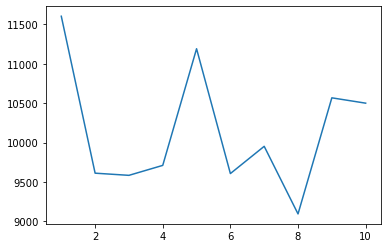

In [70]:
x = np.arange(1,len(assets)+1)
y = assets
plt.plot(x,y)
plt.show()

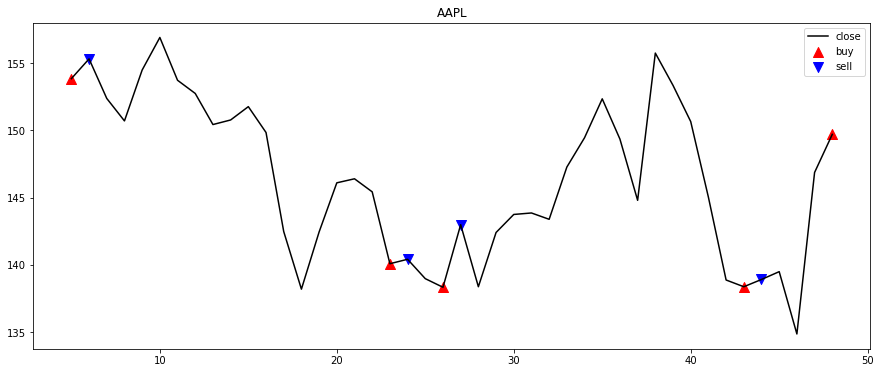

In [71]:
x_data = range(window_size,data_samples)

plt.figure(figsize=(15, 6))
plt.plot(x_data, closes,color="black")
plt.scatter(x_data, buys, marker='^',color='r',s=100)
plt.scatter(x_data, sells, marker='v',color='b',s=100)
plt.title(stock_name)
plt.legend(['close', 'buy', 'sell'])
plt.show()

In [9]:
window_size = 5
episodes = 150
capital = 10000

batch_size = 8
data_samples = len(data) - 1

In [8]:
trader = AI_Trader(window_size)
trader.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                192       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 11,011
Trainable params: 11,011
Non-trainable params: 0
_________________________________________________________________


In [10]:
assets = []
start_time = datetime.datetime.now()
for episode in range(1, episodes + 1):
  
    print("Episode: {}/{}".format(episode, episodes))

    state = state_creator(data, 10, window_size + 1)

    action = [0]
    cash = capital
    trader.inventory = []
    sells = []
    buys = []
    closes = []
    asset = 0
    # for t in tqdm(range(data_samples)):
    for t in tqdm(range(window_size,data_samples)):
        closes.append(data[t])
        
        action = trader.trade(state)

        next_state = state_creator(data, t+1, window_size + 1)
        reward = 0
        if action == 1 and cash > data[t]: #Buying
            stock = divmod(cash, data[t])
            trader.inventory.append((data[t],stock[0]))
            asset = cash
            cash -= data[t]*stock[0]
            buys.append(data[t])
            sells.append(None)
            print("purchase price: {0:.2f}, amount of purchase: {1}, cash: {2:.2f}".format(data[t],stock[0],stock[1]))
      
        elif action == 2 and len(trader.inventory) > 0: #Selling
            buy_stock = trader.inventory.pop(0)

            reward = max((data[t] - buy_stock[0])*buy_stock[1], 0)
            cash += data[t]*buy_stock[1]
            asset = cash
            sells.append(data[t])
            buys.append(None)
            print("selling price: {0:.2f}, amount of selling: {1}, cash: {2:.2f}".format(data[t],buy_stock[1],cash))
        else:
            buys.append(None)
            sells.append(None)
        if t == data_samples - 1:
            done = True
        else:
            done = False
      
        trader.memory.append((state, action, reward, next_state, done))

        state = next_state

        if done:
            print("########################")
            print("TOTAL ASSET: {:.2f}".format(asset))
            print("########################")
            assets.append(asset)
        if len(trader.memory) > batch_size:
            trader.batch_train(batch_size)
      
    if episode % 10 == 0:
        trader.model.save("ai_trader_{}.h5".format(episode))
end_time = datetime.datetime.now()
print("총 소요 시간: {}".format(end_time - start_time))

Episode: 1/150


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

purchase price: 150.70, amount of purchase: 66.0, cash: 53.80
1/1 [==============================] - 0s 44ms/step


 20%|████████████████▉                                                                  | 9/44 [00:03<00:11,  2.95it/s]

1/1 [==============================] - 0s 54ms/step


 23%|██████████████████▋                                                               | 10/44 [00:04<00:18,  1.83it/s]

1/1 [==============================] - 0s 50ms/step


 25%|████████████████████▌                                                             | 11/44 [00:06<00:23,  1.42it/s]

1/1 [==============================] - 0s 51ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:07<00:27,  1.18it/s]

selling price: 142.48, amount of selling: 66.0, cash: 9457.48
1/1 [==============================] - 0s 34ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:09<00:30,  1.03it/s]

purchase price: 138.20, amount of purchase: 68.0, cash: 59.88
1/1 [==============================] - 0s 38ms/step


 32%|██████████████████████████                                                        | 14/44 [00:10<00:31,  1.06s/it]

1/1 [==============================] - 0s 53ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:12<00:33,  1.17s/it]

selling price: 146.10, amount of selling: 68.0, cash: 9994.68
1/1 [==============================] - 0s 75ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:14<00:39,  1.42s/it]

purchase price: 146.40, amount of purchase: 68.0, cash: 39.48
1/1 [==============================] - 0s 52ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:15<00:38,  1.41s/it]

selling price: 145.43, amount of selling: 68.0, cash: 9928.72
1/1 [==============================] - 0s 34ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:17<00:36,  1.40s/it]

1/1 [==============================] - 0s 49ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:18<00:34,  1.39s/it]

purchase price: 140.42, amount of purchase: 70.0, cash: 99.32
1/1 [==============================] - 0s 47ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:20<00:34,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:21<00:36,  1.60s/it]

selling price: 138.34, amount of selling: 70.0, cash: 9783.12
1/1 [==============================] - 0s 47ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:23<00:34,  1.55s/it]

1/1 [==============================] - 0s 65ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:25<00:33,  1.61s/it]

purchase price: 138.38, amount of purchase: 70.0, cash: 96.52
1/1 [==============================] - 0s 49ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:26<00:31,  1.59s/it]

1/1 [==============================] - 0s 88ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:28<00:33,  1.74s/it]

selling price: 143.75, amount of selling: 70.0, cash: 10159.02
1/1 [==============================] - 0s 51ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:30<00:30,  1.67s/it]

1/1 [==============================] - 0s 46ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:31<00:27,  1.63s/it]

1/1 [==============================] - 0s 58ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:33<00:24,  1.55s/it]

purchase price: 147.27, amount of purchase: 68.0, cash: 144.66
1/1 [==============================] - 0s 52ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:34<00:22,  1.51s/it]

1/1 [==============================] - 0s 46ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:36<00:21,  1.52s/it]

1/1 [==============================] - 0s 49ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:37<00:19,  1.49s/it]

1/1 [==============================] - 0s 52ms/step
selling price: 149.35, amount of selling: 68.0, cash: 10300.46
1/1 [==============================] - 0s 33ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:39<00:17,  1.48s/it]

1/1 [==============================] - 0s 49ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:40<00:16,  1.49s/it]

1/1 [==============================] - 0s 33ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:41<00:14,  1.45s/it]

purchase price: 153.34, amount of purchase: 67.0, cash: 26.68
1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:43<00:12,  1.42s/it]

selling price: 150.65, amount of selling: 67.0, cash: 10120.23
1/1 [==============================] - 0s 24ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:44<00:10,  1.25s/it]

1/1 [==============================] - 0s 24ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:44<00:07,  1.09s/it]

1/1 [==============================] - 0s 74ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:46<00:07,  1.30s/it]

1/1 [==============================] - 0s 48ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:48<00:06,  1.35s/it]

purchase price: 138.92, amount of purchase: 72.0, cash: 117.99
1/1 [==============================] - 0s 50ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:49<00:05,  1.38s/it]

selling price: 139.50, amount of selling: 72.0, cash: 10161.99
1/1 [==============================] - 0s 49ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:51<00:04,  1.44s/it]

purchase price: 134.87, amount of purchase: 75.0, cash: 46.74
1/1 [==============================] - 0s 34ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:52<00:03,  1.51s/it]

1/1 [==============================] - 0s 45ms/step
selling price: 146.87, amount of selling: 75.0, cash: 11061.99
1/1 [==============================] - 0s 65ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:54<00:01,  1.51s/it]

########################
TOTAL ASSET: 11061.99
########################
1/1 [==============================] - 0s 50ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:55<00:00,  1.26s/it]

Episode: 2/150



  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


  2%|█▉                                                                                 | 1/44 [00:01<00:57,  1.35s/it]

1/1 [==============================] - 0s 35ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:56,  1.35s/it]

purchase price: 152.37, amount of purchase: 65.0, cash: 95.95
1/1 [==============================] - 0s 35ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:55,  1.35s/it]

1/1 [==============================] - 0s 50ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:53,  1.35s/it]

1/1 [==============================] - 0s 49ms/step


 11%|█████████▍                                                                         | 5/44 [00:06<00:52,  1.34s/it]

selling price: 156.90, amount of selling: 65.0, cash: 10294.45
1/1 [==============================] - 0s 49ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:51,  1.35s/it]

purchase price: 153.72, amount of purchase: 66.0, cash: 148.93
1/1 [==============================] - 0s 33ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:49,  1.35s/it]

1/1 [==============================] - 0s 49ms/step
selling price: 152.74, amount of selling: 66.0, cash: 10229.77
1/1 [==============================] - 0s 33ms/step


 18%|███████████████                                                                    | 8/44 [00:10<00:50,  1.39s/it]

purchase price: 150.43, amount of purchase: 68.0, cash: 0.53
1/1 [==============================] - 0s 34ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:48,  1.38s/it]

1/1 [==============================] - 0s 34ms/step
selling price: 150.77, amount of selling: 68.0, cash: 10252.89
1/1 [==============================] - 0s 35ms/step


 23%|██████████████████▋                                                               | 10/44 [00:13<00:48,  1.41s/it]

1/1 [==============================] - 0s 50ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:45,  1.39s/it]

1/1 [==============================] - 0s 33ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:16<00:45,  1.42s/it]

1/1 [==============================] - 0s 50ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:44,  1.44s/it]

1/1 [==============================] - 0s 48ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:43,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:20<00:41,  1.42s/it]

1/1 [==============================] - 0s 34ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:38,  1.39s/it]

1/1 [==============================] - 0s 49ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:23<00:37,  1.38s/it]

1/1 [==============================] - 0s 33ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:36,  1.41s/it]

purchase price: 140.09, amount of purchase: 73.0, cash: 26.32
1/1 [==============================] - 0s 49ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:26<00:34,  1.39s/it]

1/1 [==============================] - 0s 49ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:28<00:35,  1.47s/it]

1/1 [==============================] - 0s 50ms/step
selling price: 138.98, amount of selling: 73.0, cash: 10171.86
1/1 [==============================] - 0s 49ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:29<00:33,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:30<00:31,  1.43s/it]

1/1 [==============================] - 0s 34ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:32<00:29,  1.40s/it]

1/1 [==============================] - 0s 33ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:33<00:27,  1.38s/it]

1/1 [==============================] - 0s 49ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:35<00:26,  1.41s/it]

1/1 [==============================] - 0s 49ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:36<00:25,  1.40s/it]

1/1 [==============================] - 0s 49ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:37<00:23,  1.37s/it]

1/1 [==============================] - 0s 48ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:39<00:21,  1.36s/it]

purchase price: 147.27, amount of purchase: 69.0, cash: 10.23
1/1 [==============================] - 0s 48ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:40<00:20,  1.36s/it]

selling price: 149.45, amount of selling: 69.0, cash: 10322.28
1/1 [==============================] - 0s 51ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:41<00:19,  1.36s/it]

1/1 [==============================] - 0s 34ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:43<00:17,  1.35s/it]

1/1 [==============================] - 0s 33ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:44<00:16,  1.35s/it]

1/1 [==============================] - 0s 49ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:46<00:15,  1.43s/it]

purchase price: 155.74, amount of purchase: 66.0, cash: 43.44
1/1 [==============================] - 0s 33ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:47<00:14,  1.40s/it]

1/1 [==============================] - 0s 33ms/step
selling price: 153.34, amount of selling: 66.0, cash: 10163.88
1/1 [==============================] - 0s 33ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:48<00:12,  1.43s/it]

1/1 [==============================] - 0s 49ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:50<00:11,  1.40s/it]

1/1 [==============================] - 0s 50ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:51<00:10,  1.43s/it]

1/1 [==============================] - 0s 51ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:53<00:08,  1.45s/it]

purchase price: 138.38, amount of purchase: 73.0, cash: 62.14
1/1 [==============================] - 0s 49ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:54<00:07,  1.41s/it]

selling price: 138.92, amount of selling: 73.0, cash: 10203.30
1/1 [==============================] - 0s 34ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:55<00:05,  1.39s/it]

1/1 [==============================] - 0s 34ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:57<00:04,  1.38s/it]

1/1 [==============================] - 0s 52ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:58<00:02,  1.49s/it]

1/1 [==============================] - 0s 33ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:00<00:01,  1.48s/it]

########################
TOTAL ASSET: 10203.30
########################
1/1 [==============================] - 0s 50ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:01<00:00,  1.40s/it]


Episode: 3/150


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:04,  1.50s/it]

1/1 [==============================] - 0s 51ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:03,  1.51s/it]

1/1 [==============================] - 0s 33ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:01,  1.51s/it]

1/1 [==============================] - 0s 34ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:57,  1.44s/it]

1/1 [==============================] - 0s 36ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:56,  1.46s/it]

1/1 [==============================] - 0s 31ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:53,  1.42s/it]

1/1 [==============================] - 0s 50ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.44s/it]

1/1 [==============================] - 0s 33ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.45s/it]

1/1 [==============================] - 0s 34ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:49,  1.41s/it]

1/1 [==============================] - 0s 49ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:47,  1.39s/it]

1/1 [==============================] - 0s 49ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:45,  1.37s/it]

1/1 [==============================] - 0s 42ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:16<00:43,  1.36s/it]

1/1 [==============================] - 0s 34ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:41,  1.35s/it]

1/1 [==============================] - 0s 50ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:41,  1.39s/it]

purchase price: 142.45, amount of purchase: 70.0, cash: 28.50
1/1 [==============================] - 0s 49ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:39,  1.38s/it]

1/1 [==============================] - 0s 33ms/step
selling price: 146.10, amount of selling: 70.0, cash: 10255.50
1/1 [==============================] - 0s 50ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:39,  1.41s/it]

1/1 [==============================] - 0s 49ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:41,  1.52s/it]

1/1 [==============================] - 0s 49ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:39,  1.51s/it]

purchase price: 140.09, amount of purchase: 73.0, cash: 28.93
1/1 [==============================] - 0s 48ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:36,  1.47s/it]

1/1 [==============================] - 0s 49ms/step
selling price: 140.42, amount of selling: 73.0, cash: 10279.59
1/1 [==============================] - 0s 49ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:28<00:35,  1.49s/it]

1/1 [==============================] - 0s 49ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:33,  1.44s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:31<00:31,  1.42s/it]

1/1 [==============================] - 0s 35ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:32<00:29,  1.39s/it]

1/1 [==============================] - 0s 34ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:34<00:27,  1.37s/it]

1/1 [==============================] - 0s 50ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:35<00:25,  1.37s/it]

1/1 [==============================] - 0s 33ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:36<00:24,  1.37s/it]

1/1 [==============================] - 0s 49ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:38<00:23,  1.41s/it]

1/1 [==============================] - 0s 49ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:39<00:22,  1.42s/it]

1/1 [==============================] - 0s 38ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:41<00:21,  1.44s/it]

1/1 [==============================] - 0s 34ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:42<00:20,  1.46s/it]

1/1 [==============================] - 0s 36ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:44<00:18,  1.43s/it]

1/1 [==============================] - 0s 34ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:45<00:17,  1.44s/it]

1/1 [==============================] - 0s 50ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:47<00:16,  1.45s/it]

1/1 [==============================] - 0s 49ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:48<00:14,  1.47s/it]

1/1 [==============================] - 0s 47ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:50<00:13,  1.51s/it]

purchase price: 150.65, amount of purchase: 68.0, cash: 35.39
1/1 [==============================] - 0s 53ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:51<00:12,  1.52s/it]

1/1 [==============================] - 0s 48ms/step
selling price: 145.03, amount of selling: 68.0, cash: 9897.43
1/1 [==============================] - 0s 53ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:53<00:10,  1.57s/it]

1/1 [==============================] - 0s 35ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:54<00:09,  1.53s/it]

1/1 [==============================] - 0s 44ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:56<00:08,  1.65s/it]

1/1 [==============================] - 0s 50ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:58<00:06,  1.58s/it]

1/1 [==============================] - 0s 50ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:59<00:04,  1.62s/it]

purchase price: 134.87, amount of purchase: 73.0, cash: 51.92
1/1 [==============================] - 0s 62ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:01<00:03,  1.59s/it]

1/1 [==============================] - 0s 48ms/step
selling price: 146.87, amount of selling: 73.0, cash: 10773.43
1/1 [==============================] - 0s 46ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.62s/it]

1/1 [==============================] - 0s 48ms/step
########################
TOTAL ASSET: 10773.43
########################
1/1 [==============================] - 0s 50ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:04<00:00,  1.47s/it]


Episode: 4/150


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:12,  1.68s/it]

1/1 [==============================] - 0s 34ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:05,  1.56s/it]

purchase price: 152.37, amount of purchase: 65.0, cash: 95.95
1/1 [==============================] - 0s 47ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:00,  1.49s/it]

1/1 [==============================] - 0s 47ms/step


  9%|███████▌                                                                           | 4/44 [00:06<00:58,  1.47s/it]

1/1 [==============================] - 0s 54ms/step
selling price: 154.48, amount of selling: 65.0, cash: 10137.15
1/1 [==============================] - 0s 50ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<01:00,  1.56s/it]

purchase price: 156.90, amount of purchase: 64.0, cash: 95.55
1/1 [==============================] - 0s 49ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:59,  1.57s/it]

1/1 [==============================] - 0s 47ms/step
selling price: 153.72, amount of selling: 64.0, cash: 9933.63
1/1 [==============================] - 0s 61ms/step


 16%|█████████████▏                                                                     | 7/44 [00:11<01:00,  1.65s/it]

1/1 [==============================] - 0s 49ms/step


 18%|███████████████                                                                    | 8/44 [00:12<01:00,  1.67s/it]

1/1 [==============================] - 0s 44ms/step


 20%|████████████████▉                                                                  | 9/44 [00:14<00:58,  1.67s/it]

1/1 [==============================] - 0s 53ms/step


 23%|██████████████████▋                                                               | 10/44 [00:16<00:55,  1.62s/it]

1/1 [==============================] - 0s 49ms/step


 25%|████████████████████▌                                                             | 11/44 [00:17<00:50,  1.54s/it]

purchase price: 149.84, amount of purchase: 66.0, cash: 44.19
1/1 [==============================] - 0s 36ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:47,  1.48s/it]

1/1 [==============================] - 0s 34ms/step
selling price: 142.48, amount of selling: 66.0, cash: 9447.87
1/1 [==============================] - 0s 49ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:20<00:45,  1.48s/it]

1/1 [==============================] - 0s 33ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:44,  1.49s/it]

purchase price: 142.45, amount of purchase: 66.0, cash: 46.17
1/1 [==============================] - 0s 44ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:23<00:42,  1.45s/it]

1/1 [==============================] - 0s 39ms/step
selling price: 146.10, amount of selling: 66.0, cash: 9688.77
1/1 [==============================] - 0s 50ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:25<00:46,  1.66s/it]

purchase price: 146.40, amount of purchase: 66.0, cash: 26.37
1/1 [==============================] - 0s 50ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:26<00:44,  1.65s/it]

selling price: 145.43, amount of selling: 66.0, cash: 9624.75
1/1 [==============================] - 0s 60ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:28<00:42,  1.62s/it]

1/1 [==============================] - 0s 52ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:30<00:41,  1.65s/it]

1/1 [==============================] - 0s 48ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:31<00:40,  1.68s/it]

1/1 [==============================] - 0s 52ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:33<00:37,  1.64s/it]

1/1 [==============================] - 0s 65ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:35<00:36,  1.67s/it]

1/1 [==============================] - 0s 52ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:36<00:35,  1.70s/it]

1/1 [==============================] - 0s 51ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:38<00:33,  1.67s/it]

1/1 [==============================] - 0s 50ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:40<00:31,  1.66s/it]

1/1 [==============================] - 0s 52ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:41<00:30,  1.68s/it]

1/1 [==============================] - 0s 49ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:43<00:29,  1.73s/it]

1/1 [==============================] - 0s 63ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:45<00:27,  1.72s/it]

purchase price: 147.27, amount of purchase: 65.0, cash: 52.20
1/1 [==============================] - 0s 33ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:47<00:25,  1.69s/it]

1/1 [==============================] - 0s 42ms/step
selling price: 149.45, amount of selling: 65.0, cash: 9766.45
1/1 [==============================] - 0s 43ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:48<00:23,  1.66s/it]

1/1 [==============================] - 0s 34ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:50<00:20,  1.61s/it]

purchase price: 149.35, amount of purchase: 65.0, cash: 58.70
1/1 [==============================] - 0s 33ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:51<00:18,  1.53s/it]

1/1 [==============================] - 0s 49ms/step
selling price: 144.80, amount of selling: 65.0, cash: 9470.70
1/1 [==============================] - 0s 51ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:53<00:17,  1.55s/it]

purchase price: 155.74, amount of purchase: 60.0, cash: 126.30
1/1 [==============================] - 0s 50ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:54<00:15,  1.56s/it]

1/1 [==============================] - 0s 52ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:56<00:13,  1.52s/it]

1/1 [==============================] - 0s 56ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:57<00:12,  1.55s/it]

1/1 [==============================] - 0s 52ms/step
selling price: 145.03, amount of selling: 60.0, cash: 8828.10
1/1 [==============================] - 0s 48ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:59<00:11,  1.70s/it]

1/1 [==============================] - 0s 53ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:01<00:09,  1.66s/it]

1/1 [==============================] - 0s 50ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:02<00:08,  1.64s/it]

1/1 [==============================] - 0s 49ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:04<00:06,  1.64s/it]

1/1 [==============================] - 0s 47ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:06<00:04,  1.64s/it]

purchase price: 134.87, amount of purchase: 65.0, cash: 61.55
1/1 [==============================] - 0s 49ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:07<00:03,  1.59s/it]

1/1 [==============================] - 0s 45ms/step
selling price: 146.87, amount of selling: 65.0, cash: 9608.10
1/1 [==============================] - 0s 33ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:09<00:01,  1.61s/it]

1/1 [==============================] - 0s 43ms/step
########################
TOTAL ASSET: 9608.10
########################
1/1 [==============================] - 0s 49ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:10<00:00,  1.61s/it]

Episode: 5/150



  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


  2%|█▉                                                                                 | 1/44 [00:01<00:57,  1.35s/it]

purchase price: 155.31, amount of purchase: 64.0, cash: 60.16
1/1 [==============================] - 0s 33ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:57,  1.37s/it]

1/1 [==============================] - 0s 52ms/step
selling price: 152.37, amount of selling: 64.0, cash: 9811.84
1/1 [==============================] - 0s 49ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:58,  1.43s/it]

1/1 [==============================] - 0s 50ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:58,  1.45s/it]

1/1 [==============================] - 0s 34ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:57,  1.47s/it]

1/1 [==============================] - 0s 49ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:54,  1.42s/it]

1/1 [==============================] - 0s 53ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.44s/it]

1/1 [==============================] - 0s 49ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.46s/it]

1/1 [==============================] - 0s 49ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.47s/it]

1/1 [==============================] - 0s 50ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:50,  1.48s/it]

1/1 [==============================] - 0s 49ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:48,  1.48s/it]

1/1 [==============================] - 0s 33ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:49,  1.56s/it]

1/1 [==============================] - 0s 48ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:47,  1.55s/it]

1/1 [==============================] - 0s 39ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:44,  1.49s/it]

1/1 [==============================] - 0s 50ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:43,  1.49s/it]

1/1 [==============================] - 0s 49ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:40,  1.45s/it]

purchase price: 146.40, amount of purchase: 67.0, cash: 3.04
1/1 [==============================] - 0s 54ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:38,  1.43s/it]

1/1 [==============================] - 0s 52ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:36,  1.40s/it]

1/1 [==============================] - 0s 51ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:34,  1.39s/it]

1/1 [==============================] - 0s 49ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:28<00:33,  1.38s/it]

selling price: 138.98, amount of selling: 67.0, cash: 9314.70
1/1 [==============================] - 0s 34ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:31,  1.37s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:31<00:31,  1.41s/it]

1/1 [==============================] - 0s 48ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:30,  1.44s/it]

purchase price: 138.38, amount of purchase: 67.0, cash: 43.24
1/1 [==============================] - 0s 33ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:34<00:28,  1.41s/it]

selling price: 142.41, amount of selling: 67.0, cash: 9584.71
1/1 [==============================] - 0s 50ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:35<00:26,  1.40s/it]

1/1 [==============================] - 0s 35ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:37<00:25,  1.44s/it]

1/1 [==============================] - 0s 33ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:38<00:24,  1.45s/it]

purchase price: 143.39, amount of purchase: 66.0, cash: 120.97
1/1 [==============================] - 0s 54ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:40<00:22,  1.42s/it]

1/1 [==============================] - 0s 34ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:41<00:21,  1.40s/it]

1/1 [==============================] - 0s 49ms/step
selling price: 149.45, amount of selling: 66.0, cash: 9984.67
1/1 [==============================] - 0s 40ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:43<00:20,  1.43s/it]

1/1 [==============================] - 0s 33ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:44<00:18,  1.45s/it]

1/1 [==============================] - 0s 50ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:46<00:17,  1.47s/it]

1/1 [==============================] - 0s 55ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:47<00:16,  1.48s/it]

1/1 [==============================] - 0s 33ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:15,  1.53s/it]

1/1 [==============================] - 0s 35ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:50<00:13,  1.47s/it]

purchase price: 150.65, amount of purchase: 66.0, cash: 41.77
1/1 [==============================] - 0s 33ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:11,  1.44s/it]

selling price: 145.03, amount of selling: 66.0, cash: 9613.75
1/1 [==============================] - 0s 34ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:53<00:09,  1.42s/it]

1/1 [==============================] - 0s 33ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:54<00:08,  1.45s/it]

1/1 [==============================] - 0s 50ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:56<00:07,  1.42s/it]

1/1 [==============================] - 0s 50ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:57<00:05,  1.44s/it]

1/1 [==============================] - 0s 50ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:59<00:04,  1.46s/it]

1/1 [==============================] - 0s 35ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:00<00:02,  1.47s/it]

1/1 [==============================] - 0s 35ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:02<00:01,  1.47s/it]

1/1 [==============================] - 0s 49ms/step
########################
TOTAL ASSET: 9613.75
########################
1/1 [==============================] - 0s 53ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:03<00:00,  1.45s/it]


Episode: 6/150


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:03,  1.48s/it]

1/1 [==============================] - 0s 56ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:00,  1.44s/it]

purchase price: 152.37, amount of purchase: 65.0, cash: 95.95
1/1 [==============================] - 0s 34ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:59,  1.45s/it]

1/1 [==============================] - 0s 53ms/step
selling price: 150.70, amount of selling: 65.0, cash: 9891.45
1/1 [==============================] - 0s 39ms/step


  9%|███████▌                                                                           | 4/44 [00:05<01:00,  1.50s/it]

purchase price: 154.48, amount of purchase: 64.0, cash: 4.73
1/1 [==============================] - 0s 50ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:56,  1.45s/it]

1/1 [==============================] - 0s 54ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:54,  1.42s/it]

1/1 [==============================] - 0s 33ms/step
selling price: 153.72, amount of selling: 64.0, cash: 9842.81
1/1 [==============================] - 0s 52ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.45s/it]

1/1 [==============================] - 0s 34ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:50,  1.41s/it]

1/1 [==============================] - 0s 51ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:50,  1.43s/it]

1/1 [==============================] - 0s 49ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.45s/it]

1/1 [==============================] - 0s 48ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:48,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:48,  1.51s/it]

1/1 [==============================] - 0s 38ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:46,  1.50s/it]

1/1 [==============================] - 0s 50ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:43,  1.46s/it]

1/1 [==============================] - 0s 33ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:42,  1.45s/it]

1/1 [==============================] - 0s 48ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:41,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:41,  1.53s/it]

purchase price: 145.43, amount of purchase: 67.0, cash: 99.00
1/1 [==============================] - 0s 50ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:38,  1.48s/it]

1/1 [==============================] - 0s 49ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:36,  1.45s/it]

selling price: 140.42, amount of selling: 67.0, cash: 9507.14
1/1 [==============================] - 0s 34ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:34,  1.42s/it]

1/1 [==============================] - 0s 33ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:32,  1.40s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:31<00:30,  1.39s/it]

purchase price: 142.99, amount of purchase: 66.0, cash: 69.80
1/1 [==============================] - 0s 33ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:28,  1.38s/it]

1/1 [==============================] - 0s 49ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:34<00:27,  1.37s/it]

selling price: 142.41, amount of selling: 66.0, cash: 9468.86
1/1 [==============================] - 0s 49ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:35<00:25,  1.37s/it]

1/1 [==============================] - 0s 52ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:37<00:25,  1.40s/it]

1/1 [==============================] - 0s 51ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:38<00:24,  1.43s/it]

1/1 [==============================] - 0s 49ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:40<00:23,  1.44s/it]

1/1 [==============================] - 0s 49ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:41<00:22,  1.47s/it]

1/1 [==============================] - 0s 35ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:43<00:20,  1.47s/it]

1/1 [==============================] - 0s 49ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:44<00:19,  1.48s/it]

1/1 [==============================] - 0s 52ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:46<00:17,  1.48s/it]

1/1 [==============================] - 0s 49ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:17,  1.58s/it]

1/1 [==============================] - 0s 34ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:15,  1.55s/it]

1/1 [==============================] - 0s 44ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:13,  1.53s/it]

1/1 [==============================] - 0s 49ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:12,  1.53s/it]

1/1 [==============================] - 0s 51ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:54<00:10,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.49s/it]

1/1 [==============================] - 0s 49ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:57<00:07,  1.50s/it]

1/1 [==============================] - 0s 34ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:58<00:05,  1.45s/it]

1/1 [==============================] - 0s 36ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:59<00:04,  1.46s/it]

1/1 [==============================] - 0s 51ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:01<00:02,  1.48s/it]

1/1 [==============================] - 0s 33ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:02<00:01,  1.49s/it]

1/1 [==============================] - 0s 34ms/step
########################
TOTAL ASSET: 9468.86
########################
1/1 [==============================] - 0s 44ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:04<00:00,  1.46s/it]


Episode: 7/150


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:04,  1.49s/it]

purchase price: 155.31, amount of purchase: 64.0, cash: 60.16
1/1 [==============================] - 0s 37ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:59,  1.42s/it]

1/1 [==============================] - 0s 49ms/step
selling price: 152.37, amount of selling: 64.0, cash: 9811.84
1/1 [==============================] - 0s 50ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:00,  1.47s/it]

1/1 [==============================] - 0s 50ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:59,  1.48s/it]

1/1 [==============================] - 0s 34ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:58,  1.49s/it]

purchase price: 156.90, amount of purchase: 62.0, cash: 84.04
1/1 [==============================] - 0s 49ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.45s/it]

1/1 [==============================] - 0s 48ms/step
selling price: 153.72, amount of selling: 62.0, cash: 9614.68
1/1 [==============================] - 0s 50ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:54,  1.47s/it]

1/1 [==============================] - 0s 48ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:54,  1.52s/it]

1/1 [==============================] - 0s 33ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:52,  1.50s/it]

1/1 [==============================] - 0s 49ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:51,  1.50s/it]

1/1 [==============================] - 0s 52ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:49,  1.50s/it]

1/1 [==============================] - 0s 51ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:47,  1.50s/it]

1/1 [==============================] - 0s 51ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:46,  1.51s/it]

1/1 [==============================] - 0s 48ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:43,  1.46s/it]

1/1 [==============================] - 0s 51ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.48s/it]

1/1 [==============================] - 0s 49ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:41,  1.50s/it]

1/1 [==============================] - 0s 39ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:40,  1.50s/it]

1/1 [==============================] - 0s 36ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:39,  1.50s/it]

purchase price: 140.09, amount of purchase: 68.0, cash: 88.56
1/1 [==============================] - 0s 49ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:36,  1.46s/it]

1/1 [==============================] - 0s 33ms/step
selling price: 140.42, amount of selling: 68.0, cash: 9637.12
1/1 [==============================] - 0s 35ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:35,  1.48s/it]

1/1 [==============================] - 0s 34ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:34,  1.49s/it]

1/1 [==============================] - 0s 35ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:32,  1.49s/it]

purchase price: 142.99, amount of purchase: 67.0, cash: 56.79
1/1 [==============================] - 0s 51ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:30,  1.44s/it]

1/1 [==============================] - 0s 52ms/step
selling price: 138.38, amount of selling: 67.0, cash: 9328.25
1/1 [==============================] - 0s 42ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:29,  1.45s/it]

1/1 [==============================] - 0s 52ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:27,  1.47s/it]

1/1 [==============================] - 0s 50ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:26,  1.47s/it]

1/1 [==============================] - 0s 35ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:25,  1.47s/it]

1/1 [==============================] - 0s 49ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.47s/it]

1/1 [==============================] - 0s 49ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:23,  1.57s/it]

1/1 [==============================] - 0s 33ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.49s/it]

1/1 [==============================] - 0s 49ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:19,  1.50s/it]

1/1 [==============================] - 0s 51ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:18,  1.50s/it]

1/1 [==============================] - 0s 50ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:49<00:16,  1.50s/it]

1/1 [==============================] - 0s 33ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:14,  1.50s/it]

1/1 [==============================] - 0s 46ms/step
purchase price: 153.34, amount of purchase: 60.0, cash: 127.85
1/1 [==============================] - 0s 34ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:52<00:13,  1.49s/it]

1/1 [==============================] - 0s 33ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:11,  1.49s/it]

1/1 [==============================] - 0s 34ms/step
selling price: 145.03, amount of selling: 60.0, cash: 8829.65
1/1 [==============================] - 0s 34ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:10,  1.50s/it]

1/1 [==============================] - 0s 49ms/step
purchase price: 138.88, amount of purchase: 63.0, cash: 80.21
1/1 [==============================] - 0s 41ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:56<00:09,  1.50s/it]

1/1 [==============================] - 0s 49ms/step
selling price: 138.38, amount of selling: 63.0, cash: 8798.15
1/1 [==============================] - 0s 51ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:58<00:07,  1.50s/it]

1/1 [==============================] - 0s 54ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:59<00:05,  1.50s/it]

1/1 [==============================] - 0s 33ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:01<00:04,  1.49s/it]

purchase price: 134.87, amount of purchase: 65.0, cash: 31.60
1/1 [==============================] - 0s 54ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:02<00:02,  1.44s/it]

1/1 [==============================] - 0s 49ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.41s/it]

1/1 [==============================] - 0s 33ms/step
selling price: 149.70, amount of selling: 65.0, cash: 9762.10
########################
TOTAL ASSET: 9762.10
########################
1/1 [==============================] - 0s 49ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:05<00:00,  1.48s/it]


Episode: 8/150


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:03,  1.49s/it]

1/1 [==============================] - 0s 51ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:58,  1.39s/it]

1/1 [==============================] - 0s 34ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:58,  1.43s/it]

1/1 [==============================] - 0s 48ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:57,  1.45s/it]

1/1 [==============================] - 0s 33ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:56,  1.46s/it]

1/1 [==============================] - 0s 50ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:59,  1.57s/it]

1/1 [==============================] - 0s 52ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:56,  1.54s/it]

1/1 [==============================] - 0s 49ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:53,  1.47s/it]

1/1 [==============================] - 0s 50ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.48s/it]

1/1 [==============================] - 0s 49ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:50,  1.50s/it]

1/1 [==============================] - 0s 36ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:50,  1.53s/it]

1/1 [==============================] - 0s 31ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:48,  1.52s/it]

purchase price: 142.48, amount of purchase: 70.0, cash: 26.40
1/1 [==============================] - 0s 50ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:45,  1.47s/it]

1/1 [==============================] - 0s 49ms/step
selling price: 138.20, amount of selling: 70.0, cash: 9700.40
1/1 [==============================] - 0s 36ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:44,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:43,  1.49s/it]

1/1 [==============================] - 0s 49ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:41,  1.49s/it]

1/1 [==============================] - 0s 51ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:39,  1.48s/it]

1/1 [==============================] - 0s 49ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:38,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:37,  1.49s/it]

1/1 [==============================] - 0s 50ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:35,  1.49s/it]

1/1 [==============================] - 0s 33ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:34,  1.49s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:32,  1.50s/it]

1/1 [==============================] - 0s 35ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:31,  1.49s/it]

1/1 [==============================] - 0s 34ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:30,  1.50s/it]

1/1 [==============================] - 0s 48ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:27,  1.45s/it]

1/1 [==============================] - 0s 34ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:27,  1.55s/it]

1/1 [==============================] - 0s 50ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:26,  1.56s/it]

1/1 [==============================] - 0s 49ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:24,  1.53s/it]

1/1 [==============================] - 0s 49ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:22,  1.51s/it]

1/1 [==============================] - 0s 55ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.46s/it]

1/1 [==============================] - 0s 51ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:20,  1.54s/it]

1/1 [==============================] - 0s 59ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:20,  1.67s/it]

1/1 [==============================] - 0s 34ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:49<00:17,  1.62s/it]

1/1 [==============================] - 0s 49ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:15,  1.58s/it]

1/1 [==============================] - 0s 33ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:52<00:13,  1.55s/it]

1/1 [==============================] - 0s 49ms/step
purchase price: 150.65, amount of purchase: 64.0, cash: 58.80
1/1 [==============================] - 0s 50ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:12,  1.53s/it]

selling price: 145.03, amount of selling: 64.0, cash: 9340.72
1/1 [==============================] - 0s 51ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:10,  1.47s/it]

1/1 [==============================] - 0s 50ms/step
purchase price: 138.88, amount of purchase: 67.0, cash: 35.76
1/1 [==============================] - 0s 34ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:08,  1.49s/it]

1/1 [==============================] - 0s 38ms/step
selling price: 138.38, amount of selling: 67.0, cash: 9307.22
1/1 [==============================] - 0s 33ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:58<00:07,  1.50s/it]

1/1 [==============================] - 0s 33ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:05,  1.45s/it]

purchase price: 139.50, amount of purchase: 66.0, cash: 100.22
1/1 [==============================] - 0s 49ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:01<00:04,  1.42s/it]

1/1 [==============================] - 0s 33ms/step
selling price: 134.87, amount of selling: 66.0, cash: 9001.64
1/1 [==============================] - 0s 45ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:02<00:02,  1.45s/it]

1/1 [==============================] - 0s 34ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:04<00:01,  1.46s/it]

1/1 [==============================] - 0s 33ms/step
########################
TOTAL ASSET: 9001.64
########################
1/1 [==============================] - 0s 36ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:05<00:00,  1.50s/it]


Episode: 9/150


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:16,  1.78s/it]

1/1 [==============================] - 0s 50ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:08,  1.62s/it]

1/1 [==============================] - 0s 36ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:03,  1.55s/it]

1/1 [==============================] - 0s 33ms/step
purchase price: 150.70, amount of purchase: 66.0, cash: 53.80
1/1 [==============================] - 0s 33ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:00,  1.52s/it]

1/1 [==============================] - 0s 48ms/step
selling price: 154.48, amount of selling: 66.0, cash: 10249.48
1/1 [==============================] - 0s 34ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:59,  1.52s/it]

1/1 [==============================] - 0s 32ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:57,  1.52s/it]

1/1 [==============================] - 0s 48ms/step
purchase price: 153.72, amount of purchase: 66.0, cash: 103.96
1/1 [==============================] - 0s 34ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:56,  1.52s/it]

1/1 [==============================] - 0s 49ms/step
selling price: 152.74, amount of selling: 66.0, cash: 10184.80
1/1 [==============================] - 0s 33ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:54,  1.52s/it]

1/1 [==============================] - 0s 43ms/step


 20%|████████████████▉                                                                  | 9/44 [00:14<00:55,  1.59s/it]

1/1 [==============================] - 0s 34ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:53,  1.56s/it]

1/1 [==============================] - 0s 34ms/step


 25%|████████████████████▌                                                             | 11/44 [00:17<00:51,  1.56s/it]

1/1 [==============================] - 0s 48ms/step
purchase price: 149.84, amount of purchase: 67.0, cash: 145.52
1/1 [==============================] - 0s 48ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:49,  1.55s/it]

1/1 [==============================] - 0s 47ms/step
selling price: 142.48, amount of selling: 67.0, cash: 9691.68
1/1 [==============================] - 0s 34ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:20<00:47,  1.54s/it]

1/1 [==============================] - 0s 48ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:45,  1.53s/it]

1/1 [==============================] - 0s 48ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:23<00:44,  1.52s/it]

1/1 [==============================] - 0s 50ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:41,  1.47s/it]

1/1 [==============================] - 0s 50ms/step
purchase price: 146.40, amount of purchase: 66.0, cash: 29.28
1/1 [==============================] - 0s 51ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:26<00:39,  1.48s/it]

selling price: 145.43, amount of selling: 66.0, cash: 9627.66
1/1 [==============================] - 0s 35ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:37,  1.44s/it]

1/1 [==============================] - 0s 50ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:36,  1.45s/it]

1/1 [==============================] - 0s 50ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:35,  1.46s/it]

1/1 [==============================] - 0s 34ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:33,  1.48s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:34,  1.57s/it]

1/1 [==============================] - 0s 50ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:35<00:32,  1.54s/it]

1/1 [==============================] - 0s 49ms/step
purchase price: 138.38, amount of purchase: 69.0, cash: 79.44
1/1 [==============================] - 0s 42ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:30,  1.52s/it]

1/1 [==============================] - 0s 37ms/step
selling price: 142.41, amount of selling: 69.0, cash: 9905.73
1/1 [==============================] - 0s 50ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:38<00:28,  1.50s/it]

1/1 [==============================] - 0s 33ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:27,  1.51s/it]

1/1 [==============================] - 0s 36ms/step
purchase price: 143.86, amount of purchase: 68.0, cash: 123.25
1/1 [==============================] - 0s 34ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:25,  1.49s/it]

1/1 [==============================] - 0s 33ms/step
selling price: 143.39, amount of selling: 68.0, cash: 9873.77
1/1 [==============================] - 0s 49ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:23,  1.49s/it]

1/1 [==============================] - 0s 44ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:22,  1.49s/it]

1/1 [==============================] - 0s 49ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:21,  1.50s/it]

1/1 [==============================] - 0s 48ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:19,  1.50s/it]

1/1 [==============================] - 0s 50ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:17,  1.49s/it]

1/1 [==============================] - 0s 33ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:49<00:15,  1.45s/it]

1/1 [==============================] - 0s 33ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:14,  1.46s/it]

1/1 [==============================] - 0s 34ms/step
purchase price: 153.34, amount of purchase: 64.0, cash: 60.01
1/1 [==============================] - 0s 35ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:52<00:13,  1.47s/it]

1/1 [==============================] - 0s 48ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:11,  1.48s/it]

1/1 [==============================] - 0s 51ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:10,  1.44s/it]

1/1 [==============================] - 0s 48ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:08,  1.46s/it]

1/1 [==============================] - 0s 49ms/step
selling price: 138.38, amount of selling: 64.0, cash: 8916.33
1/1 [==============================] - 0s 48ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:58<00:07,  1.47s/it]

1/1 [==============================] - 0s 34ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:05,  1.48s/it]

1/1 [==============================] - 0s 48ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:01<00:04,  1.50s/it]

1/1 [==============================] - 0s 33ms/step
purchase price: 134.87, amount of purchase: 66.0, cash: 14.91
1/1 [==============================] - 0s 33ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:02,  1.49s/it]

1/1 [==============================] - 0s 47ms/step
selling price: 146.87, amount of selling: 66.0, cash: 9708.33
1/1 [==============================] - 0s 51ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:04<00:01,  1.57s/it]

########################
TOTAL ASSET: 9708.33
########################
1/1 [==============================] - 0s 50ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.50s/it]

Episode: 10/150



  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:04,  1.51s/it]

1/1 [==============================] - 0s 49ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:03,  1.51s/it]

1/1 [==============================] - 0s 38ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:03,  1.56s/it]

1/1 [==============================] - 0s 33ms/step


  9%|███████▌                                                                           | 4/44 [00:06<00:59,  1.49s/it]

1/1 [==============================] - 0s 49ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:58,  1.50s/it]

1/1 [==============================] - 0s 51ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:57,  1.51s/it]

1/1 [==============================] - 0s 34ms/step
purchase price: 153.72, amount of purchase: 65.0, cash: 8.20
1/1 [==============================] - 0s 48ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:55,  1.50s/it]

1/1 [==============================] - 0s 51ms/step
selling price: 152.74, amount of selling: 65.0, cash: 9936.30
1/1 [==============================] - 0s 48ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:54,  1.51s/it]

1/1 [==============================] - 0s 33ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:53,  1.53s/it]

1/1 [==============================] - 0s 51ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:51,  1.51s/it]

1/1 [==============================] - 0s 51ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:50,  1.52s/it]

1/1 [==============================] - 0s 50ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:48,  1.51s/it]

1/1 [==============================] - 0s 51ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:45,  1.46s/it]

1/1 [==============================] - 0s 33ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:43,  1.46s/it]

1/1 [==============================] - 0s 34ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.47s/it]

1/1 [==============================] - 0s 34ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:41,  1.49s/it]

1/1 [==============================] - 0s 50ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:40,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:38,  1.50s/it]

1/1 [==============================] - 0s 51ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:39,  1.59s/it]

1/1 [==============================] - 0s 34ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:37,  1.56s/it]

1/1 [==============================] - 0s 34ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:35,  1.54s/it]

1/1 [==============================] - 0s 36ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:33,  1.53s/it]

1/1 [==============================] - 0s 35ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:31,  1.52s/it]

1/1 [==============================] - 0s 50ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:30,  1.52s/it]

1/1 [==============================] - 0s 51ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:28,  1.51s/it]

1/1 [==============================] - 0s 50ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:27,  1.51s/it]

purchase price: 143.86, amount of purchase: 69.0, cash: 9.96
1/1 [==============================] - 0s 34ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:25,  1.49s/it]

1/1 [==============================] - 0s 48ms/step
selling price: 143.39, amount of selling: 69.0, cash: 9903.87
1/1 [==============================] - 0s 34ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:23,  1.50s/it]

1/1 [==============================] - 0s 35ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:22,  1.50s/it]

1/1 [==============================] - 0s 35ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:20,  1.50s/it]

1/1 [==============================] - 0s 50ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:19,  1.51s/it]

1/1 [==============================] - 0s 33ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:18,  1.51s/it]

1/1 [==============================] - 0s 48ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:49<00:16,  1.50s/it]

1/1 [==============================] - 0s 48ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:14,  1.50s/it]

1/1 [==============================] - 0s 48ms/step
purchase price: 153.34, amount of purchase: 64.0, cash: 90.11
1/1 [==============================] - 0s 52ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:52<00:13,  1.50s/it]

1/1 [==============================] - 0s 52ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:11,  1.50s/it]

1/1 [==============================] - 0s 49ms/step
selling price: 145.03, amount of selling: 64.0, cash: 9372.03
1/1 [==============================] - 0s 50ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:56<00:11,  1.58s/it]

1/1 [==============================] - 0s 48ms/step
purchase price: 138.88, amount of purchase: 67.0, cash: 67.07
1/1 [==============================] - 0s 35ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:09,  1.56s/it]

1/1 [==============================] - 0s 48ms/step
selling price: 138.38, amount of selling: 67.0, cash: 9338.53
1/1 [==============================] - 0s 49ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:59<00:07,  1.53s/it]

1/1 [==============================] - 0s 48ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:06,  1.53s/it]

1/1 [==============================] - 0s 49ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:02<00:04,  1.54s/it]

1/1 [==============================] - 0s 33ms/step
purchase price: 134.87, amount of purchase: 69.0, cash: 32.50
1/1 [==============================] - 0s 34ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:03,  1.52s/it]

1/1 [==============================] - 0s 48ms/step
selling price: 146.87, amount of selling: 69.0, cash: 10166.53
1/1 [==============================] - 0s 50ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:05<00:01,  1.50s/it]

1/1 [==============================] - 0s 50ms/step
########################
TOTAL ASSET: 10166.53
########################
1/1 [==============================] - 0s 34ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.51s/it]


Episode: 11/150


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step
purchase price: 153.84, amount of purchase: 65.0, cash: 0.40
1/1 [==============================] - 0s 49ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:03,  1.48s/it]

1/1 [==============================] - 0s 48ms/step
selling price: 155.31, amount of selling: 65.0, cash: 10095.55
1/1 [==============================] - 0s 52ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:02,  1.49s/it]

1/1 [==============================] - 0s 40ms/step
purchase price: 152.37, amount of purchase: 66.0, cash: 39.13
1/1 [==============================] - 0s 50ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:01,  1.50s/it]

1/1 [==============================] - 0s 42ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:59,  1.49s/it]

1/1 [==============================] - 0s 50ms/step
selling price: 154.48, amount of selling: 66.0, cash: 10234.81
1/1 [==============================] - 0s 33ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:58,  1.49s/it]

1/1 [==============================] - 0s 48ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:56,  1.49s/it]

1/1 [==============================] - 0s 49ms/step
purchase price: 153.72, amount of purchase: 66.0, cash: 89.29
1/1 [==============================] - 0s 34ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:55,  1.50s/it]

1/1 [==============================] - 0s 51ms/step
selling price: 152.74, amount of selling: 66.0, cash: 10170.13
1/1 [==============================] - 0s 48ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:54,  1.50s/it]

1/1 [==============================] - 0s 34ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:52,  1.49s/it]

1/1 [==============================] - 0s 51ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:50,  1.50s/it]

1/1 [==============================] - 0s 48ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:49,  1.49s/it]

1/1 [==============================] - 0s 53ms/step
purchase price: 149.84, amount of purchase: 67.0, cash: 130.85
1/1 [==============================] - 0s 48ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:48,  1.51s/it]

1/1 [==============================] - 0s 33ms/step
selling price: 142.48, amount of selling: 67.0, cash: 9677.01
1/1 [==============================] - 0s 48ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:46,  1.50s/it]

1/1 [==============================] - 0s 33ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:47,  1.59s/it]

purchase price: 142.45, amount of purchase: 67.0, cash: 132.86
1/1 [==============================] - 0s 48ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:43,  1.51s/it]

1/1 [==============================] - 0s 33ms/step
selling price: 146.10, amount of selling: 67.0, cash: 9921.56
1/1 [==============================] - 0s 33ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:42,  1.50s/it]

1/1 [==============================] - 0s 34ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:40,  1.51s/it]

1/1 [==============================] - 0s 34ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:39,  1.51s/it]

1/1 [==============================] - 0s 50ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:36,  1.47s/it]

1/1 [==============================] - 0s 51ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:35,  1.47s/it]

1/1 [==============================] - 0s 51ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:33,  1.48s/it]

1/1 [==============================] - 0s 33ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:32,  1.49s/it]

1/1 [==============================] - 0s 48ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:31,  1.49s/it]

1/1 [==============================] - 0s 47ms/step
purchase price: 138.38, amount of purchase: 71.0, cash: 96.58
1/1 [==============================] - 0s 34ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:29,  1.48s/it]

1/1 [==============================] - 0s 33ms/step
selling price: 142.41, amount of selling: 71.0, cash: 10207.69
1/1 [==============================] - 0s 33ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:28,  1.49s/it]

1/1 [==============================] - 0s 41ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:26,  1.49s/it]

1/1 [==============================] - 0s 55ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:25,  1.48s/it]

1/1 [==============================] - 0s 49ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.48s/it]

1/1 [==============================] - 0s 47ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:22,  1.48s/it]

1/1 [==============================] - 0s 49ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.49s/it]

1/1 [==============================] - 0s 33ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:19,  1.49s/it]

1/1 [==============================] - 0s 34ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:49<00:16,  1.51s/it]

1/1 [==============================] - 0s 35ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:14,  1.50s/it]

1/1 [==============================] - 0s 33ms/step
purchase price: 153.34, amount of purchase: 66.0, cash: 87.25
1/1 [==============================] - 0s 50ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:52<00:14,  1.59s/it]

1/1 [==============================] - 0s 33ms/step
selling price: 150.65, amount of selling: 66.0, cash: 10030.15
1/1 [==============================] - 0s 32ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:12,  1.56s/it]

1/1 [==============================] - 0s 49ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:10,  1.55s/it]

1/1 [==============================] - 0s 78ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:09,  1.58s/it]

1/1 [==============================] - 0s 51ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:58<00:07,  1.57s/it]

1/1 [==============================] - 0s 33ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:06,  1.55s/it]

1/1 [==============================] - 0s 48ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:01<00:04,  1.53s/it]

1/1 [==============================] - 0s 53ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:03,  1.52s/it]

1/1 [==============================] - 0s 34ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:04<00:01,  1.47s/it]

1/1 [==============================] - 0s 48ms/step
########################
TOTAL ASSET: 10030.15
########################
1/1 [==============================] - 0s 38ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.50s/it]


Episode: 12/150


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:05,  1.52s/it]

1/1 [==============================] - 0s 50ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:03,  1.52s/it]

1/1 [==============================] - 0s 49ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:02,  1.53s/it]

1/1 [==============================] - 0s 51ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:00,  1.52s/it]

1/1 [==============================] - 0s 48ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:58,  1.50s/it]

1/1 [==============================] - 0s 34ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:56,  1.50s/it]

1/1 [==============================] - 0s 53ms/step
purchase price: 153.72, amount of purchase: 65.0, cash: 8.20
1/1 [==============================] - 0s 51ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:55,  1.49s/it]

1/1 [==============================] - 0s 48ms/step
selling price: 152.74, amount of selling: 65.0, cash: 9936.30
1/1 [==============================] - 0s 48ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:53,  1.48s/it]

1/1 [==============================] - 0s 51ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:52,  1.49s/it]

purchase price: 150.77, amount of purchase: 65.0, cash: 136.25
1/1 [==============================] - 0s 48ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.46s/it]

1/1 [==============================] - 0s 51ms/step
selling price: 151.76, amount of selling: 65.0, cash: 10000.65
1/1 [==============================] - 0s 50ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:51,  1.57s/it]

1/1 [==============================] - 0s 33ms/step
purchase price: 149.84, amount of purchase: 66.0, cash: 111.21
1/1 [==============================] - 0s 50ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:49,  1.54s/it]

1/1 [==============================] - 0s 56ms/step
selling price: 142.48, amount of selling: 66.0, cash: 9514.89
1/1 [==============================] - 0s 50ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:47,  1.53s/it]

1/1 [==============================] - 0s 33ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:45,  1.51s/it]

1/1 [==============================] - 0s 50ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:43,  1.51s/it]

1/1 [==============================] - 0s 34ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:42,  1.51s/it]

1/1 [==============================] - 0s 49ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:40,  1.51s/it]

1/1 [==============================] - 0s 50ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:39,  1.51s/it]

1/1 [==============================] - 0s 33ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:37,  1.50s/it]

1/1 [==============================] - 0s 50ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:36,  1.51s/it]

1/1 [==============================] - 0s 50ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:34,  1.52s/it]

1/1 [==============================] - 0s 32ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:33,  1.52s/it]

1/1 [==============================] - 0s 37ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:31,  1.52s/it]

1/1 [==============================] - 0s 33ms/step
purchase price: 138.38, amount of purchase: 68.0, cash: 105.05
1/1 [==============================] - 0s 50ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:30,  1.51s/it]

1/1 [==============================] - 0s 48ms/step
selling price: 142.41, amount of selling: 68.0, cash: 9788.93
1/1 [==============================] - 0s 32ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:29,  1.53s/it]

1/1 [==============================] - 0s 33ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:27,  1.51s/it]

1/1 [==============================] - 0s 50ms/step
purchase price: 143.86, amount of purchase: 68.0, cash: 6.45
1/1 [==============================] - 0s 51ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:25,  1.51s/it]

1/1 [==============================] - 0s 51ms/step
selling price: 143.39, amount of selling: 68.0, cash: 9756.97
1/1 [==============================] - 0s 50ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:24,  1.52s/it]

1/1 [==============================] - 0s 47ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:44<00:23,  1.59s/it]

1/1 [==============================] - 0s 35ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:21,  1.57s/it]

1/1 [==============================] - 0s 50ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:47<00:20,  1.56s/it]

1/1 [==============================] - 0s 32ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:18,  1.55s/it]

1/1 [==============================] - 0s 50ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:50<00:16,  1.54s/it]

1/1 [==============================] - 0s 36ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:15,  1.54s/it]

1/1 [==============================] - 0s 47ms/step
purchase price: 153.34, amount of purchase: 63.0, cash: 96.55
1/1 [==============================] - 0s 48ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:13,  1.53s/it]

1/1 [==============================] - 0s 33ms/step
selling price: 150.65, amount of selling: 63.0, cash: 9587.50
1/1 [==============================] - 0s 48ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:12,  1.52s/it]

1/1 [==============================] - 0s 50ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:56<00:10,  1.51s/it]

1/1 [==============================] - 0s 34ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:08,  1.47s/it]

1/1 [==============================] - 0s 50ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:59<00:07,  1.48s/it]

1/1 [==============================] - 0s 33ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:05,  1.49s/it]

1/1 [==============================] - 0s 41ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:02<00:04,  1.49s/it]

1/1 [==============================] - 0s 33ms/step
purchase price: 134.87, amount of purchase: 71.0, cash: 11.73
1/1 [==============================] - 0s 53ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:02,  1.50s/it]

1/1 [==============================] - 0s 34ms/step
selling price: 146.87, amount of selling: 71.0, cash: 10439.50
1/1 [==============================] - 0s 33ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:05<00:01,  1.50s/it]

1/1 [==============================] - 0s 50ms/step
########################
TOTAL ASSET: 10439.50
########################
1/1 [==============================] - 0s 50ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.51s/it]

Episode: 13/150



  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:03,  1.47s/it]

1/1 [==============================] - 0s 33ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:02,  1.48s/it]

1/1 [==============================] - 0s 33ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:01,  1.49s/it]

1/1 [==============================] - 0s 37ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:59,  1.50s/it]

1/1 [==============================] - 0s 50ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:58,  1.50s/it]

1/1 [==============================] - 0s 50ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<01:00,  1.60s/it]

1/1 [==============================] - 0s 33ms/step
purchase price: 153.72, amount of purchase: 65.0, cash: 8.20
1/1 [==============================] - 0s 44ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:57,  1.56s/it]

1/1 [==============================] - 0s 48ms/step
selling price: 152.74, amount of selling: 65.0, cash: 9936.30
1/1 [==============================] - 0s 42ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:55,  1.54s/it]

1/1 [==============================] - 0s 34ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:53,  1.52s/it]

1/1 [==============================] - 0s 33ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:51,  1.52s/it]

1/1 [==============================] - 0s 51ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:49,  1.51s/it]

1/1 [==============================] - 0s 34ms/step
purchase price: 149.84, amount of purchase: 66.0, cash: 46.86
1/1 [==============================] - 0s 33ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:47,  1.49s/it]

1/1 [==============================] - 0s 51ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:45,  1.46s/it]

1/1 [==============================] - 0s 48ms/step
selling price: 138.20, amount of selling: 66.0, cash: 9168.06
1/1 [==============================] - 0s 34ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:43,  1.47s/it]

1/1 [==============================] - 0s 43ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.47s/it]

1/1 [==============================] - 0s 33ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:41,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:40,  1.49s/it]

1/1 [==============================] - 0s 50ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:38,  1.48s/it]

1/1 [==============================] - 0s 51ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:37,  1.49s/it]

1/1 [==============================] - 0s 51ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:34,  1.45s/it]

1/1 [==============================] - 0s 33ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:33,  1.46s/it]

1/1 [==============================] - 0s 34ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:32,  1.47s/it]

1/1 [==============================] - 0s 51ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:31,  1.48s/it]

1/1 [==============================] - 0s 35ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:28,  1.44s/it]

1/1 [==============================] - 0s 48ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:27,  1.46s/it]

1/1 [==============================] - 0s 49ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:26,  1.48s/it]

1/1 [==============================] - 0s 48ms/step
purchase price: 143.86, amount of purchase: 63.0, cash: 104.88
1/1 [==============================] - 0s 44ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:26,  1.59s/it]

1/1 [==============================] - 0s 34ms/step
selling price: 143.39, amount of selling: 63.0, cash: 9138.45
1/1 [==============================] - 0s 50ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:24,  1.56s/it]

1/1 [==============================] - 0s 49ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:22,  1.53s/it]

1/1 [==============================] - 0s 48ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:21,  1.52s/it]

1/1 [==============================] - 0s 33ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:19,  1.52s/it]

1/1 [==============================] - 0s 64ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:18,  1.53s/it]

1/1 [==============================] - 0s 46ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:49<00:17,  1.63s/it]

1/1 [==============================] - 0s 49ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:16,  1.62s/it]

1/1 [==============================] - 0s 48ms/step
purchase price: 153.34, amount of purchase: 59.0, cash: 91.39
1/1 [==============================] - 0s 50ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:14,  1.60s/it]

1/1 [==============================] - 0s 33ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:12,  1.57s/it]

1/1 [==============================] - 0s 48ms/step
selling price: 145.03, amount of selling: 59.0, cash: 8648.16
1/1 [==============================] - 0s 41ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:56<00:10,  1.56s/it]

1/1 [==============================] - 0s 33ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:09,  1.55s/it]

1/1 [==============================] - 0s 33ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:59<00:07,  1.54s/it]

1/1 [==============================] - 0s 48ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:06,  1.53s/it]

1/1 [==============================] - 0s 34ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:02<00:04,  1.53s/it]

1/1 [==============================] - 0s 48ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:03,  1.53s/it]

1/1 [==============================] - 0s 36ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:05<00:01,  1.54s/it]

1/1 [==============================] - 0s 34ms/step
########################
TOTAL ASSET: 8648.16
########################
1/1 [==============================] - 0s 50ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.51s/it]


Episode: 14/150


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 55ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:04,  1.49s/it]

1/1 [==============================] - 0s 55ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:02,  1.48s/it]

1/1 [==============================] - 0s 31ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:06,  1.62s/it]

1/1 [==============================] - 0s 33ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:03,  1.58s/it]

1/1 [==============================] - 0s 34ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<01:00,  1.55s/it]

1/1 [==============================] - 0s 51ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:58,  1.53s/it]

1/1 [==============================] - 0s 50ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:56,  1.52s/it]

1/1 [==============================] - 0s 50ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:54,  1.52s/it]

1/1 [==============================] - 0s 48ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:52,  1.51s/it]

1/1 [==============================] - 0s 35ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:50,  1.50s/it]

1/1 [==============================] - 0s 34ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:49,  1.50s/it]

purchase price: 149.84, amount of purchase: 66.0, cash: 110.56
1/1 [==============================] - 0s 50ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:46,  1.45s/it]

1/1 [==============================] - 0s 50ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:45,  1.47s/it]

1/1 [==============================] - 0s 33ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:44,  1.48s/it]

1/1 [==============================] - 0s 49ms/step
selling price: 142.45, amount of selling: 66.0, cash: 9512.26
1/1 [==============================] - 0s 33ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:43,  1.49s/it]

1/1 [==============================] - 0s 34ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:41,  1.49s/it]

1/1 [==============================] - 0s 34ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:40,  1.50s/it]

1/1 [==============================] - 0s 49ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:39,  1.51s/it]

1/1 [==============================] - 0s 49ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:37,  1.52s/it]

1/1 [==============================] - 0s 34ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:36,  1.51s/it]

1/1 [==============================] - 0s 33ms/step
purchase price: 138.98, amount of purchase: 68.0, cash: 61.62
1/1 [==============================] - 0s 49ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:36,  1.59s/it]

1/1 [==============================] - 0s 34ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:34,  1.56s/it]

1/1 [==============================] - 0s 49ms/step
selling price: 142.99, amount of selling: 68.0, cash: 9784.94
1/1 [==============================] - 0s 50ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:32,  1.54s/it]

1/1 [==============================] - 0s 48ms/step
purchase price: 138.38, amount of purchase: 70.0, cash: 98.34
1/1 [==============================] - 0s 36ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:30,  1.53s/it]

1/1 [==============================] - 0s 49ms/step
selling price: 142.41, amount of selling: 70.0, cash: 10067.04
1/1 [==============================] - 0s 48ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:28,  1.52s/it]

1/1 [==============================] - 0s 36ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:27,  1.51s/it]

purchase price: 143.86, amount of purchase: 69.0, cash: 140.70
1/1 [==============================] - 0s 33ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:24,  1.46s/it]

1/1 [==============================] - 0s 34ms/step
selling price: 143.39, amount of selling: 69.0, cash: 10034.61
1/1 [==============================] - 0s 34ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:23,  1.47s/it]

1/1 [==============================] - 0s 48ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:22,  1.47s/it]

1/1 [==============================] - 0s 35ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:20,  1.49s/it]

1/1 [==============================] - 0s 51ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:19,  1.49s/it]

1/1 [==============================] - 0s 51ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:18,  1.57s/it]

1/1 [==============================] - 0s 48ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:50<00:17,  1.62s/it]

1/1 [==============================] - 0s 49ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:15,  1.57s/it]

1/1 [==============================] - 0s 51ms/step
purchase price: 153.34, amount of purchase: 65.0, cash: 67.51
1/1 [==============================] - 0s 35ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:13,  1.55s/it]

1/1 [==============================] - 0s 33ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:12,  1.53s/it]

1/1 [==============================] - 0s 48ms/step
selling price: 145.03, amount of selling: 65.0, cash: 9494.46
1/1 [==============================] - 0s 33ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:56<00:10,  1.52s/it]

1/1 [==============================] - 0s 33ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:09,  1.51s/it]

1/1 [==============================] - 0s 48ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:59<00:07,  1.51s/it]

1/1 [==============================] - 0s 50ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:06,  1.50s/it]

1/1 [==============================] - 0s 46ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:02<00:04,  1.50s/it]

1/1 [==============================] - 0s 33ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:03,  1.58s/it]

1/1 [==============================] - 0s 52ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:05<00:01,  1.57s/it]

1/1 [==============================] - 0s 48ms/step
########################
TOTAL ASSET: 9494.46
########################
1/1 [==============================] - 0s 35ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.52s/it]


Episode: 15/150


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:04,  1.49s/it]

1/1 [==============================] - 0s 52ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:02,  1.49s/it]

1/1 [==============================] - 0s 50ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:01,  1.49s/it]

1/1 [==============================] - 0s 50ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:59,  1.50s/it]

1/1 [==============================] - 0s 33ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:58,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:56,  1.49s/it]

1/1 [==============================] - 0s 48ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:55,  1.51s/it]

1/1 [==============================] - 0s 56ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:54,  1.52s/it]

1/1 [==============================] - 0s 48ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:52,  1.51s/it]

1/1 [==============================] - 0s 59ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:51,  1.52s/it]

1/1 [==============================] - 0s 47ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:50,  1.53s/it]

1/1 [==============================] - 0s 67ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:48,  1.53s/it]

1/1 [==============================] - 0s 41ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:47,  1.52s/it]

1/1 [==============================] - 0s 52ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:45,  1.51s/it]

1/1 [==============================] - 0s 51ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:43,  1.51s/it]

1/1 [==============================] - 0s 34ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:42,  1.50s/it]

1/1 [==============================] - 0s 50ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:40,  1.51s/it]

1/1 [==============================] - 0s 32ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:39,  1.51s/it]

1/1 [==============================] - 0s 34ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:40,  1.60s/it]

1/1 [==============================] - 0s 55ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:38,  1.60s/it]

1/1 [==============================] - 0s 63ms/step
purchase price: 138.98, amount of purchase: 71.0, cash: 132.42
1/1 [==============================] - 0s 56ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:32<00:40,  1.75s/it]

1/1 [==============================] - 0s 48ms/step
selling price: 138.34, amount of selling: 71.0, cash: 9954.56
1/1 [==============================] - 0s 46ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:34<00:37,  1.71s/it]

1/1 [==============================] - 0s 41ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:35<00:34,  1.65s/it]

1/1 [==============================] - 0s 56ms/step
purchase price: 138.38, amount of purchase: 71.0, cash: 129.58
1/1 [==============================] - 0s 40ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:37<00:32,  1.64s/it]

1/1 [==============================] - 0s 47ms/step
selling price: 142.41, amount of selling: 71.0, cash: 10240.69
1/1 [==============================] - 0s 50ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:39<00:31,  1.64s/it]

1/1 [==============================] - 0s 46ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:40<00:29,  1.65s/it]

1/1 [==============================] - 0s 45ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:42<00:26,  1.58s/it]

1/1 [==============================] - 0s 39ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:43<00:25,  1.58s/it]

1/1 [==============================] - 0s 48ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:45<00:23,  1.56s/it]

1/1 [==============================] - 0s 34ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:46<00:21,  1.53s/it]

1/1 [==============================] - 0s 42ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:48<00:19,  1.53s/it]

1/1 [==============================] - 0s 49ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:49<00:18,  1.52s/it]

1/1 [==============================] - 0s 35ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:51<00:16,  1.51s/it]

1/1 [==============================] - 0s 49ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:52<00:15,  1.50s/it]

1/1 [==============================] - 0s 37ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:54<00:13,  1.49s/it]

1/1 [==============================] - 0s 48ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:55<00:11,  1.49s/it]

1/1 [==============================] - 0s 48ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:57<00:10,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:58<00:08,  1.48s/it]

1/1 [==============================] - 0s 49ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:00<00:07,  1.57s/it]

1/1 [==============================] - 0s 33ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:01<00:06,  1.55s/it]

1/1 [==============================] - 0s 48ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:03<00:04,  1.52s/it]

1/1 [==============================] - 0s 33ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:04<00:03,  1.51s/it]

1/1 [==============================] - 0s 35ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:06<00:01,  1.52s/it]

1/1 [==============================] - 0s 49ms/step
########################
TOTAL ASSET: 10240.69
########################
1/1 [==============================] - 0s 50ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:07<00:00,  1.54s/it]


Episode: 16/150


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:04,  1.51s/it]

1/1 [==============================] - 0s 34ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:03,  1.51s/it]

1/1 [==============================] - 0s 32ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:01,  1.50s/it]

1/1 [==============================] - 0s 50ms/step


  9%|███████▌                                                                           | 4/44 [00:06<00:59,  1.50s/it]

1/1 [==============================] - 0s 50ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:58,  1.50s/it]

1/1 [==============================] - 0s 48ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:56,  1.49s/it]

1/1 [==============================] - 0s 34ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:55,  1.51s/it]

1/1 [==============================] - 0s 34ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:54,  1.50s/it]

1/1 [==============================] - 0s 41ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:52,  1.50s/it]

1/1 [==============================] - 0s 48ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:51,  1.50s/it]

1/1 [==============================] - 0s 51ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:49,  1.51s/it]

1/1 [==============================] - 0s 38ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:48,  1.52s/it]

1/1 [==============================] - 0s 34ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:49,  1.60s/it]

1/1 [==============================] - 0s 33ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:47,  1.58s/it]

1/1 [==============================] - 0s 49ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:45,  1.56s/it]

1/1 [==============================] - 0s 34ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:43,  1.54s/it]

1/1 [==============================] - 0s 33ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:41,  1.54s/it]

1/1 [==============================] - 0s 34ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:39,  1.53s/it]

1/1 [==============================] - 0s 51ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:38,  1.53s/it]

1/1 [==============================] - 0s 34ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:36,  1.53s/it]

1/1 [==============================] - 0s 32ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:34,  1.52s/it]

1/1 [==============================] - 0s 35ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:33,  1.51s/it]

1/1 [==============================] - 0s 34ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:31,  1.51s/it]

1/1 [==============================] - 0s 48ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:30,  1.51s/it]

1/1 [==============================] - 0s 33ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:27,  1.46s/it]

1/1 [==============================] - 0s 49ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:26,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:25,  1.50s/it]

1/1 [==============================] - 0s 51ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:24,  1.51s/it]

1/1 [==============================] - 0s 34ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:22,  1.51s/it]

1/1 [==============================] - 0s 51ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:21,  1.51s/it]

1/1 [==============================] - 0s 48ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:19,  1.51s/it]

1/1 [==============================] - 0s 33ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:18,  1.52s/it]

1/1 [==============================] - 0s 50ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:50<00:16,  1.51s/it]

1/1 [==============================] - 0s 49ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:16,  1.60s/it]

1/1 [==============================] - 0s 34ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:14,  1.58s/it]

1/1 [==============================] - 0s 50ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:12,  1.56s/it]

1/1 [==============================] - 0s 42ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:56<00:10,  1.54s/it]

1/1 [==============================] - 0s 48ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:09,  1.53s/it]

1/1 [==============================] - 0s 34ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:59<00:07,  1.53s/it]

1/1 [==============================] - 0s 34ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:06,  1.52s/it]

1/1 [==============================] - 0s 33ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:02<00:04,  1.52s/it]

1/1 [==============================] - 0s 48ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:03,  1.53s/it]

1/1 [==============================] - 0s 33ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:05<00:01,  1.51s/it]

########################
TOTAL ASSET: 0.00
########################
1/1 [==============================] - 0s 50ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.51s/it]

Episode: 17/150



  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  2%|█▉                                                                                 | 1/44 [00:01<00:58,  1.36s/it]

1/1 [==============================] - 0s 50ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:00,  1.44s/it]

1/1 [==============================] - 0s 37ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:00,  1.46s/it]

1/1 [==============================] - 0s 33ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:58,  1.47s/it]

1/1 [==============================] - 0s 48ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:57,  1.49s/it]

1/1 [==============================] - 0s 50ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:56,  1.49s/it]

1/1 [==============================] - 0s 34ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:55,  1.51s/it]

1/1 [==============================] - 0s 34ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:54,  1.51s/it]

1/1 [==============================] - 0s 51ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:52,  1.51s/it]

1/1 [==============================] - 0s 50ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:51,  1.52s/it]

1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:55,  1.68s/it]

1/1 [==============================] - 0s 33ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:52,  1.65s/it]

1/1 [==============================] - 0s 34ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:20<00:50,  1.62s/it]

1/1 [==============================] - 0s 49ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:47,  1.58s/it]

1/1 [==============================] - 0s 50ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:23<00:45,  1.56s/it]

1/1 [==============================] - 0s 41ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:43,  1.55s/it]

1/1 [==============================] - 0s 50ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:26<00:41,  1.52s/it]

1/1 [==============================] - 0s 50ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:39,  1.52s/it]

1/1 [==============================] - 0s 48ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:29<00:37,  1.51s/it]

1/1 [==============================] - 0s 51ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:36,  1.52s/it]

1/1 [==============================] - 0s 33ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:32<00:34,  1.50s/it]

1/1 [==============================] - 0s 47ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:32,  1.49s/it]

1/1 [==============================] - 0s 50ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:35<00:31,  1.49s/it]

1/1 [==============================] - 0s 34ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:29,  1.49s/it]

1/1 [==============================] - 0s 48ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:38<00:28,  1.48s/it]

1/1 [==============================] - 0s 33ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:26,  1.47s/it]

1/1 [==============================] - 0s 48ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:25,  1.48s/it]

1/1 [==============================] - 0s 51ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:23,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:22,  1.48s/it]

1/1 [==============================] - 0s 48ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:20,  1.48s/it]

1/1 [==============================] - 0s 34ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:47<00:20,  1.58s/it]

1/1 [==============================] - 0s 33ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:18,  1.55s/it]

1/1 [==============================] - 0s 50ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:50<00:16,  1.54s/it]

1/1 [==============================] - 0s 51ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:15,  1.52s/it]

1/1 [==============================] - 0s 50ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:13,  1.52s/it]

1/1 [==============================] - 0s 50ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:12,  1.52s/it]

1/1 [==============================] - 0s 33ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:56<00:10,  1.51s/it]

1/1 [==============================] - 0s 48ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:09,  1.51s/it]

1/1 [==============================] - 0s 31ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:59<00:07,  1.52s/it]

1/1 [==============================] - 0s 51ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:06,  1.51s/it]

1/1 [==============================] - 0s 48ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:02<00:04,  1.49s/it]

1/1 [==============================] - 0s 33ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:02,  1.48s/it]

1/1 [==============================] - 0s 43ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:05<00:01,  1.48s/it]

1/1 [==============================] - 0s 34ms/step
########################
TOTAL ASSET: 0.00
########################
1/1 [==============================] - 0s 34ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.51s/it]

Episode: 18/150



  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:04,  1.49s/it]

1/1 [==============================] - 0s 48ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:02,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:01,  1.49s/it]

1/1 [==============================] - 0s 49ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:59,  1.49s/it]

1/1 [==============================] - 0s 34ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:58,  1.50s/it]

1/1 [==============================] - 0s 34ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<01:00,  1.59s/it]

1/1 [==============================] - 0s 34ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:57,  1.57s/it]

1/1 [==============================] - 0s 48ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:55,  1.54s/it]

1/1 [==============================] - 0s 51ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:53,  1.52s/it]

1/1 [==============================] - 0s 35ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:53,  1.56s/it]

1/1 [==============================] - 0s 50ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:50,  1.54s/it]

1/1 [==============================] - 0s 34ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:49,  1.53s/it]

1/1 [==============================] - 0s 50ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:47,  1.52s/it]

1/1 [==============================] - 0s 48ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:45,  1.52s/it]

1/1 [==============================] - 0s 51ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:44,  1.53s/it]

1/1 [==============================] - 0s 51ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:42,  1.53s/it]

1/1 [==============================] - 0s 37ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:40,  1.51s/it]

1/1 [==============================] - 0s 48ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:39,  1.51s/it]

1/1 [==============================] - 0s 50ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:37,  1.50s/it]

1/1 [==============================] - 0s 33ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:36,  1.50s/it]

1/1 [==============================] - 0s 42ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:34,  1.50s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:33,  1.51s/it]

1/1 [==============================] - 0s 51ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:35<00:32,  1.53s/it]

1/1 [==============================] - 0s 34ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:30,  1.53s/it]

1/1 [==============================] - 0s 33ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:38<00:29,  1.53s/it]

1/1 [==============================] - 0s 33ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:29,  1.62s/it]

1/1 [==============================] - 0s 50ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:41<00:26,  1.58s/it]

1/1 [==============================] - 0s 49ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:24,  1.56s/it]

1/1 [==============================] - 0s 50ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:44<00:23,  1.56s/it]

1/1 [==============================] - 0s 44ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:46<00:21,  1.55s/it]

1/1 [==============================] - 0s 34ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:47<00:19,  1.53s/it]

1/1 [==============================] - 0s 42ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:18,  1.52s/it]

1/1 [==============================] - 0s 48ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:50<00:16,  1.50s/it]

1/1 [==============================] - 0s 49ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:14,  1.50s/it]

1/1 [==============================] - 0s 33ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:13,  1.50s/it]

1/1 [==============================] - 0s 51ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:11,  1.50s/it]

1/1 [==============================] - 0s 48ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:56<00:10,  1.49s/it]

1/1 [==============================] - 0s 40ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:08,  1.49s/it]

1/1 [==============================] - 0s 34ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:59<00:07,  1.49s/it]

1/1 [==============================] - 0s 33ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:06,  1.51s/it]

1/1 [==============================] - 0s 34ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:02<00:04,  1.51s/it]

1/1 [==============================] - 0s 32ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:03,  1.50s/it]

1/1 [==============================] - 0s 34ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:05<00:01,  1.51s/it]

1/1 [==============================] - 0s 49ms/step
########################
TOTAL ASSET: 0.00
########################
1/1 [==============================] - 0s 48ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.52s/it]

Episode: 19/150



  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:03,  1.47s/it]

1/1 [==============================] - 0s 48ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:01,  1.47s/it]

1/1 [==============================] - 0s 53ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:10,  1.73s/it]

1/1 [==============================] - 0s 38ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:04,  1.62s/it]

1/1 [==============================] - 0s 38ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<01:01,  1.57s/it]

1/1 [==============================] - 0s 49ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:58,  1.55s/it]

1/1 [==============================] - 0s 34ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:56,  1.54s/it]

1/1 [==============================] - 0s 43ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:54,  1.52s/it]

1/1 [==============================] - 0s 34ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:52,  1.51s/it]

1/1 [==============================] - 0s 48ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:51,  1.51s/it]

1/1 [==============================] - 0s 49ms/step


 25%|████████████████████▌                                                             | 11/44 [00:17<00:52,  1.59s/it]

1/1 [==============================] - 0s 41ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:52,  1.65s/it]

1/1 [==============================] - 0s 49ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:20<00:49,  1.61s/it]

1/1 [==============================] - 0s 50ms/step


 32%|██████████████████████████                                                        | 14/44 [00:22<00:47,  1.58s/it]

1/1 [==============================] - 0s 48ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:23<00:45,  1.56s/it]

1/1 [==============================] - 0s 34ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:42,  1.53s/it]

1/1 [==============================] - 0s 34ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:26<00:41,  1.52s/it]

1/1 [==============================] - 0s 49ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:39,  1.52s/it]

1/1 [==============================] - 0s 50ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:29<00:37,  1.52s/it]

1/1 [==============================] - 0s 49ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:35,  1.50s/it]

1/1 [==============================] - 0s 50ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:32<00:34,  1.51s/it]

1/1 [==============================] - 0s 33ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:33,  1.50s/it]

1/1 [==============================] - 0s 41ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:35<00:33,  1.59s/it]

1/1 [==============================] - 0s 41ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:37<00:30,  1.55s/it]

1/1 [==============================] - 0s 32ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:38<00:29,  1.53s/it]

1/1 [==============================] - 0s 50ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:40<00:27,  1.52s/it]

1/1 [==============================] - 0s 48ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:41<00:25,  1.50s/it]

1/1 [==============================] - 0s 32ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:43<00:24,  1.51s/it]

1/1 [==============================] - 0s 48ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:44<00:22,  1.51s/it]

1/1 [==============================] - 0s 50ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:46<00:21,  1.51s/it]

1/1 [==============================] - 0s 41ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:47<00:19,  1.52s/it]

1/1 [==============================] - 0s 33ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:49<00:18,  1.53s/it]

1/1 [==============================] - 0s 44ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:50<00:16,  1.53s/it]

1/1 [==============================] - 0s 50ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:52<00:15,  1.52s/it]

1/1 [==============================] - 0s 49ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:13,  1.51s/it]

1/1 [==============================] - 0s 32ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:55<00:12,  1.51s/it]

1/1 [==============================] - 0s 49ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:56<00:10,  1.51s/it]

1/1 [==============================] - 0s 47ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:58<00:08,  1.50s/it]

1/1 [==============================] - 0s 42ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:59<00:07,  1.49s/it]

1/1 [==============================] - 0s 50ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:01<00:06,  1.51s/it]

1/1 [==============================] - 0s 36ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:03<00:04,  1.59s/it]

1/1 [==============================] - 0s 33ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:04<00:03,  1.56s/it]

1/1 [==============================] - 0s 49ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:06<00:01,  1.53s/it]

1/1 [==============================] - 0s 52ms/step
########################
TOTAL ASSET: 0.00
########################
1/1 [==============================] - 0s 49ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:07<00:00,  1.53s/it]


Episode: 20/150


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:03,  1.48s/it]

1/1 [==============================] - 0s 48ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:01,  1.47s/it]

1/1 [==============================] - 0s 50ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:00,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:59,  1.48s/it]

1/1 [==============================] - 0s 48ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:58,  1.50s/it]

1/1 [==============================] - 0s 51ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:57,  1.51s/it]

1/1 [==============================] - 0s 33ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:56,  1.51s/it]

purchase price: 152.74, amount of purchase: 65.0, cash: 71.90
1/1 [==============================] - 0s 48ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.47s/it]

1/1 [==============================] - 0s 33ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:50,  1.49s/it]

1/1 [==============================] - 0s 33ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:49,  1.50s/it]

1/1 [==============================] - 0s 50ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:48,  1.50s/it]

1/1 [==============================] - 0s 35ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:46,  1.50s/it]

1/1 [==============================] - 0s 41ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:45,  1.50s/it]

1/1 [==============================] - 0s 41ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:43,  1.51s/it]

1/1 [==============================] - 0s 33ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:42,  1.53s/it]

1/1 [==============================] - 0s 48ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:41,  1.53s/it]

1/1 [==============================] - 0s 42ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:41,  1.61s/it]

1/1 [==============================] - 0s 34ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:39,  1.58s/it]

1/1 [==============================] - 0s 50ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:37,  1.56s/it]

1/1 [==============================] - 0s 50ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:35,  1.56s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:33,  1.54s/it]

1/1 [==============================] - 0s 34ms/step
selling price: 142.99, amount of selling: 65.0, cash: 9366.25
1/1 [==============================] - 0s 34ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:31,  1.52s/it]

1/1 [==============================] - 0s 48ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:30,  1.50s/it]

1/1 [==============================] - 0s 45ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:28,  1.48s/it]

1/1 [==============================] - 0s 48ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:26,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:25,  1.50s/it]

1/1 [==============================] - 0s 41ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:24,  1.50s/it]

1/1 [==============================] - 0s 51ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:22,  1.50s/it]

1/1 [==============================] - 0s 33ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:20,  1.49s/it]

1/1 [==============================] - 0s 34ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:19,  1.48s/it]

1/1 [==============================] - 0s 49ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:17,  1.49s/it]

1/1 [==============================] - 0s 33ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:49<00:16,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:14,  1.48s/it]

1/1 [==============================] - 0s 51ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:52<00:13,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:11,  1.49s/it]

1/1 [==============================] - 0s 54ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:10,  1.52s/it]

1/1 [==============================] - 0s 53ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:09,  1.56s/it]

1/1 [==============================] - 0s 43ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:59<00:08,  1.65s/it]

1/1 [==============================] - 0s 34ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:06,  1.59s/it]

1/1 [==============================] - 0s 33ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:02<00:04,  1.56s/it]

1/1 [==============================] - 0s 50ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:03,  1.56s/it]

1/1 [==============================] - 0s 50ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:05<00:01,  1.55s/it]

1/1 [==============================] - 0s 49ms/step
########################
TOTAL ASSET: 9366.25
########################
1/1 [==============================] - 0s 33ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.52s/it]


Episode: 21/150


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:05,  1.52s/it]

1/1 [==============================] - 0s 42ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:02,  1.48s/it]

1/1 [==============================] - 0s 39ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:00,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:59,  1.50s/it]

1/1 [==============================] - 0s 49ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:58,  1.51s/it]

1/1 [==============================] - 0s 42ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:57,  1.52s/it]

1/1 [==============================] - 0s 48ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:56,  1.52s/it]

1/1 [==============================] - 0s 42ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:54,  1.52s/it]

1/1 [==============================] - 0s 32ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:53,  1.52s/it]

1/1 [==============================] - 0s 45ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:52,  1.53s/it]

1/1 [==============================] - 0s 33ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:50,  1.52s/it]

1/1 [==============================] - 0s 33ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:48,  1.52s/it]

1/1 [==============================] - 0s 48ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:47,  1.52s/it]

1/1 [==============================] - 0s 34ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:45,  1.51s/it]

1/1 [==============================] - 0s 48ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:46,  1.60s/it]

1/1 [==============================] - 0s 50ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:44,  1.58s/it]

1/1 [==============================] - 0s 34ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:26<00:42,  1.56s/it]

1/1 [==============================] - 0s 48ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:40,  1.55s/it]

1/1 [==============================] - 0s 43ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:29<00:38,  1.54s/it]

1/1 [==============================] - 0s 43ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:36,  1.54s/it]

1/1 [==============================] - 0s 50ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:32<00:35,  1.52s/it]

1/1 [==============================] - 0s 41ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:33,  1.52s/it]

1/1 [==============================] - 0s 50ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:35<00:31,  1.51s/it]

1/1 [==============================] - 0s 48ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:30,  1.51s/it]

1/1 [==============================] - 0s 34ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:38<00:28,  1.50s/it]

1/1 [==============================] - 0s 34ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:26,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:41<00:25,  1.50s/it]

1/1 [==============================] - 0s 41ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:24,  1.50s/it]

1/1 [==============================] - 0s 34ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:44<00:22,  1.49s/it]

1/1 [==============================] - 0s 41ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:21,  1.51s/it]

1/1 [==============================] - 0s 49ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:47<00:19,  1.50s/it]

1/1 [==============================] - 0s 34ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:17,  1.50s/it]

1/1 [==============================] - 0s 48ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:50<00:17,  1.58s/it]

1/1 [==============================] - 0s 34ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:15,  1.54s/it]

1/1 [==============================] - 0s 41ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:13,  1.52s/it]

1/1 [==============================] - 0s 48ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:12,  1.51s/it]

1/1 [==============================] - 0s 49ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:56<00:10,  1.52s/it]

1/1 [==============================] - 0s 41ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:09,  1.51s/it]

1/1 [==============================] - 0s 41ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:59<00:07,  1.51s/it]

1/1 [==============================] - 0s 49ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:06,  1.52s/it]

1/1 [==============================] - 0s 49ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:02<00:04,  1.52s/it]

1/1 [==============================] - 0s 43ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:03,  1.52s/it]

1/1 [==============================] - 0s 33ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:05<00:01,  1.51s/it]

1/1 [==============================] - 0s 34ms/step
########################
TOTAL ASSET: 0.00
########################
1/1 [==============================] - 0s 49ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.52s/it]


Episode: 22/150


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:04,  1.51s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:02,  1.48s/it]

1/1 [==============================] - 0s 35ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:00,  1.48s/it]

1/1 [==============================] - 0s 51ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:59,  1.49s/it]

1/1 [==============================] - 0s 47ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:58,  1.51s/it]

1/1 [==============================] - 0s 49ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:56,  1.50s/it]

1/1 [==============================] - 0s 34ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:55,  1.49s/it]

1/1 [==============================] - 0s 40ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:53,  1.49s/it]

1/1 [==============================] - 0s 41ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:52,  1.49s/it]

1/1 [==============================] - 0s 33ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:53,  1.58s/it]

1/1 [==============================] - 0s 33ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:50,  1.55s/it]

1/1 [==============================] - 0s 49ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:49,  1.53s/it]

1/1 [==============================] - 0s 47ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:47,  1.52s/it]

1/1 [==============================] - 0s 49ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:45,  1.50s/it]

1/1 [==============================] - 0s 42ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:43,  1.50s/it]

1/1 [==============================] - 0s 33ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:41,  1.49s/it]

1/1 [==============================] - 0s 34ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:40,  1.48s/it]

1/1 [==============================] - 0s 49ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:38,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:37,  1.48s/it]

1/1 [==============================] - 0s 33ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:35,  1.49s/it]

1/1 [==============================] - 0s 32ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:34,  1.51s/it]

1/1 [==============================] - 0s 41ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:33,  1.50s/it]

1/1 [==============================] - 0s 33ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:31,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:29,  1.50s/it]

1/1 [==============================] - 0s 51ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:28,  1.50s/it]

1/1 [==============================] - 0s 33ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:26,  1.49s/it]

1/1 [==============================] - 0s 48ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:25,  1.48s/it]

1/1 [==============================] - 0s 43ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.47s/it]

1/1 [==============================] - 0s 50ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:23,  1.55s/it]

1/1 [==============================] - 0s 48ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:22,  1.63s/it]

1/1 [==============================] - 0s 42ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:47<00:21,  1.67s/it]

1/1 [==============================] - 0s 41ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:20,  1.68s/it]

1/1 [==============================] - 0s 42ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:50<00:18,  1.64s/it]

1/1 [==============================] - 0s 50ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:52<00:16,  1.60s/it]

1/1 [==============================] - 0s 34ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:14,  1.56s/it]

1/1 [==============================] - 0s 51ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:55<00:12,  1.57s/it]

1/1 [==============================] - 0s 61ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:56<00:11,  1.63s/it]

1/1 [==============================] - 0s 49ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:58<00:09,  1.60s/it]

1/1 [==============================] - 0s 34ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:59<00:07,  1.57s/it]

1/1 [==============================] - 0s 42ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:01<00:06,  1.55s/it]

1/1 [==============================] - 0s 58ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:03<00:04,  1.63s/it]

1/1 [==============================] - 0s 41ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:05<00:03,  1.70s/it]

1/1 [==============================] - 0s 33ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:06<00:01,  1.66s/it]

1/1 [==============================] - 0s 51ms/step
########################
TOTAL ASSET: 0.00
########################
1/1 [==============================] - 0s 42ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:07<00:00,  1.54s/it]


Episode: 23/150


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:04,  1.50s/it]

1/1 [==============================] - 0s 32ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:06,  1.59s/it]

1/1 [==============================] - 0s 35ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:03,  1.55s/it]

1/1 [==============================] - 0s 34ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:00,  1.52s/it]

1/1 [==============================] - 0s 43ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:58,  1.51s/it]

1/1 [==============================] - 0s 43ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:57,  1.50s/it]

1/1 [==============================] - 0s 34ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:59,  1.60s/it]

1/1 [==============================] - 0s 41ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:56,  1.57s/it]

1/1 [==============================] - 0s 32ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:54,  1.54s/it]

1/1 [==============================] - 0s 42ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:52,  1.53s/it]

1/1 [==============================] - 0s 33ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:50,  1.55s/it]

1/1 [==============================] - 0s 34ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:49,  1.56s/it]

1/1 [==============================] - 0s 42ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:20<00:48,  1.55s/it]

1/1 [==============================] - 0s 41ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:45,  1.50s/it]

1/1 [==============================] - 0s 48ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:23<00:43,  1.50s/it]

1/1 [==============================] - 0s 48ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:42,  1.51s/it]

1/1 [==============================] - 0s 48ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:40,  1.50s/it]

1/1 [==============================] - 0s 43ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:38,  1.49s/it]

purchase price: 140.09, amount of purchase: 71.0, cash: 53.61
1/1 [==============================] - 0s 48ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:36,  1.45s/it]

1/1 [==============================] - 0s 48ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:35,  1.46s/it]

1/1 [==============================] - 0s 44ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:33,  1.48s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:32,  1.47s/it]

1/1 [==============================] - 0s 48ms/step
selling price: 142.99, amount of selling: 71.0, cash: 10205.90
1/1 [==============================] - 0s 48ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:31,  1.50s/it]

1/1 [==============================] - 0s 33ms/step
purchase price: 138.38, amount of purchase: 73.0, cash: 104.16
1/1 [==============================] - 0s 33ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:30,  1.52s/it]

1/1 [==============================] - 0s 48ms/step
selling price: 142.41, amount of selling: 73.0, cash: 10500.09
1/1 [==============================] - 0s 48ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:38<00:30,  1.61s/it]

1/1 [==============================] - 0s 49ms/step
purchase price: 143.75, amount of purchase: 73.0, cash: 6.34
1/1 [==============================] - 0s 37ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:28,  1.58s/it]

1/1 [==============================] - 0s 43ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:41<00:26,  1.55s/it]

1/1 [==============================] - 0s 33ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:24,  1.54s/it]

1/1 [==============================] - 0s 35ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:44<00:22,  1.53s/it]

1/1 [==============================] - 0s 32ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:21,  1.52s/it]

1/1 [==============================] - 0s 41ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:47<00:19,  1.53s/it]

1/1 [==============================] - 0s 42ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:18,  1.51s/it]

1/1 [==============================] - 0s 41ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:50<00:16,  1.52s/it]

1/1 [==============================] - 0s 33ms/step
selling price: 155.74, amount of selling: 73.0, cash: 11375.36
1/1 [==============================] - 0s 35ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:15,  1.51s/it]

1/1 [==============================] - 0s 33ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:13,  1.50s/it]

1/1 [==============================] - 0s 42ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:12,  1.51s/it]

1/1 [==============================] - 0s 37ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:56<00:10,  1.51s/it]

1/1 [==============================] - 0s 49ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:09,  1.51s/it]

1/1 [==============================] - 0s 42ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:59<00:07,  1.52s/it]

1/1 [==============================] - 0s 47ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:06,  1.52s/it]

1/1 [==============================] - 0s 48ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:02<00:04,  1.53s/it]

1/1 [==============================] - 0s 50ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:03,  1.52s/it]

1/1 [==============================] - 0s 41ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:05<00:01,  1.52s/it]

1/1 [==============================] - 0s 49ms/step
########################
TOTAL ASSET: 11375.36
########################
1/1 [==============================] - 0s 41ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.52s/it]


Episode: 24/150


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:19,  1.84s/it]

1/1 [==============================] - 0s 34ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:09,  1.66s/it]

1/1 [==============================] - 0s 34ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:04,  1.58s/it]

1/1 [==============================] - 0s 49ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:01,  1.55s/it]

1/1 [==============================] - 0s 44ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:59,  1.54s/it]

1/1 [==============================] - 0s 49ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:58,  1.54s/it]

1/1 [==============================] - 0s 42ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:56,  1.54s/it]

1/1 [==============================] - 0s 36ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:55,  1.55s/it]

1/1 [==============================] - 0s 42ms/step


 20%|████████████████▉                                                                  | 9/44 [00:14<00:53,  1.53s/it]

1/1 [==============================] - 0s 51ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:51,  1.53s/it]

1/1 [==============================] - 0s 42ms/step


 25%|████████████████████▌                                                             | 11/44 [00:17<00:49,  1.51s/it]

1/1 [==============================] - 0s 41ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:47,  1.50s/it]

1/1 [==============================] - 0s 41ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:46,  1.49s/it]

1/1 [==============================] - 0s 34ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:44,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:41,  1.47s/it]

1/1 [==============================] - 0s 33ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:39,  1.48s/it]

1/1 [==============================] - 0s 56ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:40,  1.54s/it]

1/1 [==============================] - 0s 33ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:29<00:38,  1.55s/it]

1/1 [==============================] - 0s 32ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:37,  1.55s/it]

1/1 [==============================] - 0s 49ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:32<00:34,  1.52s/it]

1/1 [==============================] - 0s 69ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:35,  1.63s/it]

1/1 [==============================] - 0s 58ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:36<00:36,  1.75s/it]

1/1 [==============================] - 0s 56ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:37<00:34,  1.71s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:39<00:32,  1.72s/it]

1/1 [==============================] - 0s 40ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:41<00:30,  1.70s/it]

1/1 [==============================] - 0s 33ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:42<00:28,  1.67s/it]

1/1 [==============================] - 0s 50ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:44<00:25,  1.62s/it]

1/1 [==============================] - 0s 42ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:45<00:23,  1.57s/it]

1/1 [==============================] - 0s 33ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:47<00:21,  1.55s/it]

1/1 [==============================] - 0s 38ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:48<00:19,  1.53s/it]

1/1 [==============================] - 0s 42ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:50<00:18,  1.50s/it]

1/1 [==============================] - 0s 33ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:51<00:16,  1.49s/it]

1/1 [==============================] - 0s 33ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:52<00:14,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:54<00:13,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:55<00:11,  1.48s/it]

1/1 [==============================] - 0s 33ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:57<00:10,  1.48s/it]

1/1 [==============================] - 0s 36ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:58<00:08,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:00<00:07,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:01<00:05,  1.47s/it]

1/1 [==============================] - 0s 43ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:03<00:04,  1.48s/it]

1/1 [==============================] - 0s 34ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:05<00:03,  1.57s/it]

1/1 [==============================] - 0s 42ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:06<00:01,  1.56s/it]

1/1 [==============================] - 0s 49ms/step
########################
TOTAL ASSET: 0.00
########################
1/1 [==============================] - 0s 50ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:07<00:00,  1.54s/it]


Episode: 25/150


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:06,  1.54s/it]

1/1 [==============================] - 0s 33ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:03,  1.51s/it]

1/1 [==============================] - 0s 42ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:01,  1.51s/it]

1/1 [==============================] - 0s 50ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:00,  1.50s/it]

1/1 [==============================] - 0s 33ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:58,  1.50s/it]

1/1 [==============================] - 0s 36ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:57,  1.52s/it]

1/1 [==============================] - 0s 49ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:56,  1.52s/it]

1/1 [==============================] - 0s 41ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:54,  1.52s/it]

1/1 [==============================] - 0s 41ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:52,  1.50s/it]

1/1 [==============================] - 0s 41ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:51,  1.51s/it]

1/1 [==============================] - 0s 45ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:47,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:46,  1.45s/it]

1/1 [==============================] - 0s 28ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:45,  1.46s/it]

1/1 [==============================] - 0s 47ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:43,  1.46s/it]

1/1 [==============================] - 0s 41ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.46s/it]

1/1 [==============================] - 0s 50ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:43,  1.56s/it]

1/1 [==============================] - 0s 52ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:42,  1.57s/it]

1/1 [==============================] - 0s 53ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:42,  1.62s/it]

1/1 [==============================] - 0s 46ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:29<00:41,  1.66s/it]

1/1 [==============================] - 0s 47ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:39,  1.64s/it]

1/1 [==============================] - 0s 33ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:32<00:37,  1.62s/it]

1/1 [==============================] - 0s 52ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:35,  1.62s/it]

1/1 [==============================] - 0s 46ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:35<00:33,  1.60s/it]

1/1 [==============================] - 0s 46ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:37<00:31,  1.59s/it]

1/1 [==============================] - 0s 50ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:38<00:30,  1.60s/it]

1/1 [==============================] - 0s 47ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:40<00:29,  1.63s/it]

1/1 [==============================] - 0s 51ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:42<00:28,  1.67s/it]

1/1 [==============================] - 0s 49ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:43<00:26,  1.68s/it]

1/1 [==============================] - 0s 47ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:45<00:25,  1.68s/it]

1/1 [==============================] - 0s 41ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:47<00:23,  1.67s/it]

1/1 [==============================] - 0s 50ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:48<00:21,  1.68s/it]

1/1 [==============================] - 0s 45ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:50<00:19,  1.66s/it]

1/1 [==============================] - 0s 55ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:52<00:18,  1.67s/it]

1/1 [==============================] - 0s 56ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:53<00:16,  1.68s/it]

1/1 [==============================] - 0s 63ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:55<00:15,  1.71s/it]

1/1 [==============================] - 0s 45ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:57<00:13,  1.68s/it]

1/1 [==============================] - 0s 46ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:59<00:12,  1.76s/it]

1/1 [==============================] - 0s 53ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:00<00:10,  1.73s/it]

1/1 [==============================] - 0s 45ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:02<00:08,  1.69s/it]

1/1 [==============================] - 0s 40ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:04<00:06,  1.69s/it]

1/1 [==============================] - 0s 49ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:05<00:05,  1.69s/it]

1/1 [==============================] - 0s 52ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:07<00:03,  1.68s/it]

1/1 [==============================] - 0s 34ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:09<00:01,  1.66s/it]

1/1 [==============================] - 0s 51ms/step
########################
TOTAL ASSET: 0.00
########################
1/1 [==============================] - 0s 43ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:10<00:00,  1.61s/it]


Episode: 26/150


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:15,  1.75s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:12,  1.73s/it]

1/1 [==============================] - 0s 48ms/step


  7%|█████▋                                                                             | 3/44 [00:05<01:10,  1.72s/it]

1/1 [==============================] - 0s 50ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:08,  1.71s/it]

1/1 [==============================] - 0s 48ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:05,  1.67s/it]

1/1 [==============================] - 0s 54ms/step


 14%|███████████▎                                                                       | 6/44 [00:10<01:05,  1.73s/it]

1/1 [==============================] - 0s 57ms/step


 16%|█████████████▏                                                                     | 7/44 [00:11<01:03,  1.70s/it]

1/1 [==============================] - 0s 48ms/step


 18%|███████████████                                                                    | 8/44 [00:13<01:01,  1.71s/it]

1/1 [==============================] - 0s 51ms/step


 20%|████████████████▉                                                                  | 9/44 [00:15<00:59,  1.70s/it]

1/1 [==============================] - 0s 61ms/step


 23%|██████████████████▋                                                               | 10/44 [00:17<00:57,  1.70s/it]

1/1 [==============================] - 0s 52ms/step


 25%|████████████████████▌                                                             | 11/44 [00:18<00:55,  1.68s/it]

1/1 [==============================] - 0s 48ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:20<00:53,  1.67s/it]

1/1 [==============================] - 0s 64ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:21<00:51,  1.65s/it]

1/1 [==============================] - 0s 34ms/step


 32%|██████████████████████████                                                        | 14/44 [00:23<00:52,  1.76s/it]

1/1 [==============================] - 0s 48ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:25<00:49,  1.69s/it]

1/1 [==============================] - 0s 50ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:27<00:46,  1.66s/it]

1/1 [==============================] - 0s 51ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:28<00:45,  1.68s/it]

1/1 [==============================] - 0s 51ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:30<00:43,  1.69s/it]

1/1 [==============================] - 0s 50ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:32<00:42,  1.70s/it]

1/1 [==============================] - 0s 40ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:33<00:40,  1.68s/it]

1/1 [==============================] - 0s 50ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:35<00:38,  1.67s/it]

1/1 [==============================] - 0s 46ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:37<00:36,  1.68s/it]

1/1 [==============================] - 0s 45ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:38<00:35,  1.68s/it]

1/1 [==============================] - 0s 34ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:40<00:32,  1.65s/it]

1/1 [==============================] - 0s 47ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:42<00:31,  1.66s/it]

1/1 [==============================] - 0s 36ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:43<00:28,  1.60s/it]

1/1 [==============================] - 0s 33ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:45<00:27,  1.60s/it]

1/1 [==============================] - 0s 48ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:46<00:25,  1.62s/it]

1/1 [==============================] - 0s 62ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:48<00:24,  1.63s/it]

1/1 [==============================] - 0s 33ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:50<00:22,  1.61s/it]

1/1 [==============================] - 0s 51ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:51<00:21,  1.64s/it]

1/1 [==============================] - 0s 45ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:53<00:19,  1.66s/it]

1/1 [==============================] - 0s 49ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:55<00:18,  1.64s/it]

1/1 [==============================] - 0s 53ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:57<00:17,  1.76s/it]

1/1 [==============================] - 0s 52ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:58<00:15,  1.70s/it]

1/1 [==============================] - 0s 53ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [01:00<00:13,  1.68s/it]

1/1 [==============================] - 0s 47ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:01<00:11,  1.63s/it]

1/1 [==============================] - 0s 48ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:03<00:09,  1.62s/it]

1/1 [==============================] - 0s 48ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:05<00:08,  1.61s/it]

1/1 [==============================] - 0s 49ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:06<00:06,  1.61s/it]

1/1 [==============================] - 0s 44ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:08<00:04,  1.59s/it]

1/1 [==============================] - 0s 44ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:09<00:03,  1.58s/it]

1/1 [==============================] - 0s 39ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:11<00:01,  1.56s/it]

1/1 [==============================] - 0s 37ms/step
########################
TOTAL ASSET: 0.00
########################
1/1 [==============================] - 0s 37ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:12<00:00,  1.65s/it]


Episode: 27/150


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 55ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:13,  1.72s/it]

1/1 [==============================] - 0s 58ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:11,  1.70s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▋                                                                             | 3/44 [00:05<01:15,  1.85s/it]

1/1 [==============================] - 0s 49ms/step


  9%|███████▌                                                                           | 4/44 [00:07<01:11,  1.78s/it]

1/1 [==============================] - 0s 52ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:08,  1.75s/it]

1/1 [==============================] - 0s 47ms/step


 14%|███████████▎                                                                       | 6/44 [00:10<01:05,  1.72s/it]

1/1 [==============================] - 0s 51ms/step


 16%|█████████████▏                                                                     | 7/44 [00:12<01:02,  1.68s/it]

1/1 [==============================] - 0s 53ms/step


 18%|███████████████                                                                    | 8/44 [00:14<01:04,  1.78s/it]

1/1 [==============================] - 0s 33ms/step


 20%|████████████████▉                                                                  | 9/44 [00:15<01:00,  1.74s/it]

1/1 [==============================] - 0s 50ms/step


 23%|██████████████████▋                                                               | 10/44 [00:17<00:57,  1.70s/it]

1/1 [==============================] - 0s 46ms/step


 25%|████████████████████▌                                                             | 11/44 [00:18<00:55,  1.67s/it]

1/1 [==============================] - 0s 43ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:20<00:52,  1.63s/it]

1/1 [==============================] - 0s 51ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:22<00:49,  1.61s/it]

1/1 [==============================] - 0s 45ms/step


 32%|██████████████████████████                                                        | 14/44 [00:23<00:47,  1.59s/it]

1/1 [==============================] - 0s 47ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:25<00:47,  1.63s/it]

1/1 [==============================] - 0s 50ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:26<00:44,  1.61s/it]

1/1 [==============================] - 0s 53ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:27<00:47,  1.70s/it]


KeyboardInterrupt: 

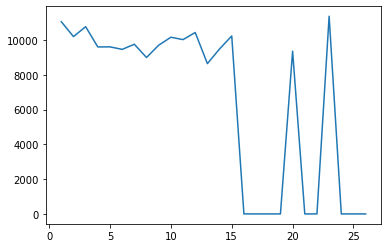

In [11]:
x = np.arange(1,len(assets)+1)
y = assets
plt.plot(x,y)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (44,) and (17,)

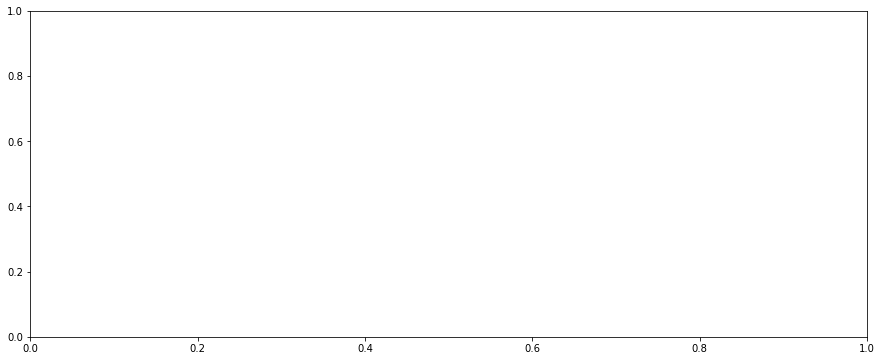

In [12]:
x_data = range(window_size,data_samples)

plt.figure(figsize=(15, 6))
plt.plot(x_data, closes,color="black")
plt.scatter(x_data, buys, marker='^',color='r',s=100)
plt.scatter(x_data, sells, marker='v',color='b',s=100)
plt.title(stock_name)
plt.legend(['close', 'buy', 'sell'])
plt.show()